# Analysis 2

- Use data 1, where RNAseq data are projected into LV space at each timepoint first, then LVs are substracted
- Check for normality within each group and accross all group
- Pairwise comparison between each group using Wilcoxon-test for non normal LV and t-test for normal LV
- Divide data into Progressor vs non Progressor and Reverter vs non-Reverter
- Comparison between each group using Wilcoxon-test for non normal LV and t-test for normal LV
- Plot boxplot for LVs differentially expressed accros comparison p-value < 0.005

## load packages 

In [1]:
library(tidyverse, warn.conflicts=FALSE)
library("ggpubr")
library(reticulate)
library(jsonlite)
library(rstatix)
library(DT)
library(IRdisplay)
library(rstatix)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




### Importing RNAseq data

#### Data 1: Projecting data at individual timepoint into LV space then substract LV at the two timepoints

In [2]:
DAISY_diff_proj_1 <- readRDS(paste0("output/gp_RNA_proj_1.rds"))
DAISY_diff_proj_2 <- readRDS(paste0("output/gp_RNA_proj_2.rds"))
## difference between the two 
Daisy_diff <- DAISY_diff_proj_2[,2:988] - DAISY_diff_proj_1[,2:988]
DAISY_LV_diff <- DAISY_diff_proj_1
DAISY_LV_diff[,2:988] <- Daisy_diff
head(DAISY_LV_diff,5)

LV_names <- colnames(DAISY_LV_diff)[2:988]

ID      LV1         LV2          LV3          LV4          LV5         
1 00041-0 -0.11140203  0.021818790 0.0535675047 -0.067776314  0.004886417
2 00110-0  0.07227066  0.031820395 0.0017124683 -0.005697077 -0.001916463
3 00139-0  0.06975536  0.061082676 0.0900765329 -0.150849341  0.078259462
4 00159-0  0.07806625 -0.397310916 0.0416671066 -0.086283757 -0.015893750
5 00174-0  0.06436926 -0.005807392 0.0002256534 -0.018971156  0.014683138
  LV6         LV7         LV8         LV9         ⋯ LV979        LV980       
1  0.01349279  0.21384901  0.02506244  0.02602336 ⋯ -0.056442779 -0.031079155
2 -0.01898339 -0.20061505 -0.04795546 -0.01731360 ⋯  0.000887035  0.040743388
3 -0.05815224  0.03904118 -0.02301079  0.06903941 ⋯  0.034678138  0.005332622
4  0.03211687 -0.09401872 -0.02830306  0.06440271 ⋯ -0.039194495  0.006062143
5  0.02381849  0.08329137  0.01727677 -0.00179197 ⋯ -0.009958269  0.016433316
  LV981        LV982        LV983       LV984      LV985       LV986       
1 -0.039551201  0.003216641 -0.05876335  0.1235162  0.21851990 -0.002038538
2  0.020157308  0.009622277  0.01772465  0.2701976 -0.03313927 -0.022591122
3  0.022895423 -0.014878154  0.05049221  0.1304244 -0.21384840 -0.008425512
4 -0.043149383 -0.048552636  0.03130918  0.4727951 -0.32350161  0.087352049
5 -0.006428658  0.008130357 -0.04461014 -0.1835539  0.01664969 -0.010559217
  LV987       Group     
1 -0.01719279 Maintainer
2 -0.06483950 Reverter  
3 -0.06776475 Reverter  
4  0.03400709 Maintainer
5  0.10689044 Progressor

In [3]:
# function that assess the normality of all variability in a data frame and returns, 2 datasets
# Dataset 1: contains for each column, the statistic, p value of Shapiro wilk test and wether the data is considered normally distributed or not
# Dataaset 2: returns a count of the number of variables that are normally and non normally distributed. 

dist_count <- function(df){
    my_outputs <- c()
    shapiro_out <- sapply(prog_data, shapiro.test)
    long_data <- data.frame(t(shapiro_out))[,c("statistic","p.value")]
    long_data$normality <- ifelse(long_data$p.value < 0.05, "non-normal","normal")
    dist_count_df <- long_data%>% group_by(normality)%>%summarise(count = n())
    my_outputs[[1]] <- long_data
    my_outputs[[2]] <- dist_count_df
    return(my_outputs)
    }

## Prioritizing LVs differentially expressed accross IA progression status, Progressor, Maintainer, Reverter

#### Shapiro-Wilk Test for normality

The null hypothesis: the data is drawn from a normally distributed population.

- If p-value <0.05 we reject the null hypothesis. Data is not normally distributed
- If p-value >0.05 we fail to reject the null hypothesis. Data is normally distributed

In [4]:
#  Distribution by group and overall, applying dist_function, getting vector of variables that are not normally distrobuted
# Datasets Progressor (25 x 987)
prog_data <- DAISY_LV_diff[DAISY_LV_diff$Group == "Progressor",LV_names]
progressor <- dist_count(prog_data)[[1]]
non_norm_prog <- rownames(progressor[progressor$normality == "non-normal",])

#  Datasets Maintainer (64x987), applying dist_function, getting vector of variables that are not normally distrobuted
maint_data <- DAISY_LV_diff[DAISY_LV_diff$Group == "Maintainer",LV_names]
maintainer <- dist_count(maint_data)[[1]]
non_norm_maint <- rownames(maintainer[maintainer$normality == "non-normal",])

#  Datasets Reverter  (47 x 987), applying dist_function, getting vector of variables that are not normally distrobuted
revert_data <- DAISY_LV_diff[DAISY_LV_diff$Group == "Reverter",LV_names]
reverter <- dist_count(revert_data)[[1]]
non_norm_revert <- rownames(reverter[reverter$normality == "non-normal",])

# Datasets All data ( 136 x 987), applying dist_function, getting vector of variables that are not normally distrobuted
all_data <- DAISY_LV_diff[,LV_names]
all_dat <- dist_count(all_data)[[1]]
non_norm_all_dat <- rownames(all_dat[all_dat$normality == "non-normal",])

#Checking if variables for each group are the same as all data
identical(non_norm_prog, non_norm_maint)&identical(non_norm_prog, non_norm_revert)&identical(non_norm_prog, non_norm_all_dat)

#display normality of each LV
datatable(all_dat)

[1] TRUE

HTML widgets cannot be represented in plain text (need html)

## Comparing difference in expression between IA groups accross all LVs

In [5]:
normal_LV <- setdiff(LV_names, non_norm_all_dat)
length(normal_LV)

[1] 858

In [6]:
## Non normal data
all_wilcox <- c()
for (i in 1:length(non_norm_all_dat)) {
wilcox_out <- DAISY_LV_diff%>%pairwise_wilcox_test(as.formula(paste0(non_norm_all_dat[i]," ~ Group")))
wilcox_out$Comp <- paste0(str_sub(wilcox_out$group1, 1, 1),"x",str_sub(wilcox_out$group2, 1, 1))
all_wilcox <- rbind(all_wilcox,wilcox_out)
      }
new_data <- all_wilcox[,c(1,7,10)]
new_data$distribution <- "non-normal"
wider_wilcox <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

# Normal data

all_t.test <- c()
for (i in 1:length(normal_LV)) {
stat.test <- pairwise_t_test(DAISY_LV_diff, as.formula(paste0(normal_LV[i]," ~ Group")), paired = FALSE)
stat.test$Comp <- paste0(str_sub(stat.test$group1, 1, 1),"x",str_sub(stat.test$group2, 1, 1))
all_t.test <- rbind(all_t.test,stat.test)
      }
new_data <- all_t.test[,c(1,6,10)]
new_data$distribution <- "normal"
wider_t.test <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

all_data_test <- rbind(wider_wilcox,wider_t.test)

# adjsut p values for multiple comparison
all_data_test$p.adj.MxR <- p.adjust(all_data_test$MxR, method = "bonferroni")
all_data_test$p.adj.MxP <- p.adjust(all_data_test$MxP, method = "bonferroni")
all_data_test$p.adj.RxP <- p.adjust(all_data_test$RxP, method = "bonferroni")

In [7]:
dim(all_data_test)
datatable(all_data_test)

[1] 987   8

HTML widgets cannot be represented in plain text (need html)

In [8]:
# LVs where at least one comparison significantly different
sig_all <- all_data_test[all_data_test$MxR <0.005| all_data_test$MxP <0.005|all_data_test$RxP <0.005,]
dim(sig_all)
sig_all
# LVs that differs Maintainer from all
sig_1 <- all_data_test[all_data_test$MxR <0.005&all_data_test$MxP <0.005,]
dim(sig_1)
sig_1
# LVs that differs Progressor from all
sig_2 <- all_data_test[all_data_test$MxP <0.005&all_data_test$RxP <0.005,]
dim(sig_2)
# LVs that differs Reverter from all
sig_3 <- all_data_test[all_data_test$MxR <0.005&all_data_test$RxP <0.005,]
dim(sig_3)
sig_3

[1] 27  8

.y.   distribution MxR      MxP     RxP      p.adj.MxR p.adj.MxP p.adj.RxP
1  LV568 non-normal   0.276000 0.00400 0.061000 1.000000  1         1.000000 
2  LV50  normal       0.214000 0.04680 0.004620 1.000000  1         1.000000 
3  LV92  normal       0.000738 0.08220 0.313000 0.728406  1         1.000000 
4  LV116 normal       0.002760 0.15200 0.322000 1.000000  1         1.000000 
5  LV140 normal       0.002750 0.42300 0.112000 1.000000  1         1.000000 
6  LV230 normal       0.008670 0.13200 0.000608 1.000000  1         0.600096 
7  LV265 normal       0.006190 0.26700 0.001600 1.000000  1         1.000000 
8  LV269 normal       0.003560 0.05800 0.632000 1.000000  1         1.000000 
9  LV278 normal       0.004420 0.01930 0.993000 1.000000  1         1.000000 
10 LV288 normal       0.003870 0.00418 0.621000 1.000000  1         1.000000 
11 LV299 normal       0.058600 0.14900 0.004870 1.000000  1         1.000000 
12 LV322 normal       0.412000 0.00437 0.035500 1.000000  1         1.000000 
13 LV326 normal       0.004720 0.97400 0.025300 1.000000  1         1.000000 
14 LV368 normal       0.000469 0.16500 0.148000 0.462903  1         1.000000 
15 LV382 normal       0.302000 0.00147 0.023500 1.000000  1         1.000000 
16 LV474 normal       0.000262 0.04310 0.336000 0.258594  1         1.000000 
17 LV503 normal       0.000695 0.60600 0.029400 0.685965  1         1.000000 
18 LV539 normal       0.005150 0.00323 0.517000 1.000000  1         1.000000 
19 LV555 normal       0.003050 0.34900 0.151000 1.000000  1         1.000000 
20 LV613 normal       0.003000 0.38200 0.133000 1.000000  1         1.000000 
21 LV648 normal       0.000454 0.11300 0.206000 0.448098  1         1.000000 
22 LV733 normal       0.001320 0.45900 0.068100 1.000000  1         1.000000 
23 LV857 normal       0.022300 0.14600 0.001780 1.000000  1         1.000000 
24 LV870 normal       0.022300 0.21000 0.003290 1.000000  1         1.000000 
25 LV884 normal       0.002840 0.27600 0.190000 1.000000  1         1.000000 
26 LV908 normal       0.000174 0.00932 0.629000 0.171738  1         1.000000 
27 LV910 normal       0.004890 0.16000 0.000502 1.000000  1         0.495474

[1] 1 8

.y.   distribution MxR     MxP     RxP   p.adj.MxR p.adj.MxP p.adj.RxP
1 LV288 normal       0.00387 0.00418 0.621 1         1         1

[1] 0 8

[1] 1 8

.y.   distribution MxR     MxP  RxP      p.adj.MxR p.adj.MxP p.adj.RxP
1 LV910 normal       0.00489 0.16 0.000502 1         1         0.495474

## Prioritizing LVs differentially expressed in Progressor vs non-progressor and Reverter vs non-Reverter

In [11]:
#### Progressor vs non-progressor 
DAISY_prog <- DAISY_LV_diff
DAISY_prog$group_2 <- ifelse(DAISY_prog$Group == "Progressor","Progressor","non-Progressor")
DAISY_prog <- DAISY_prog[,c(LV_names,"group_2")]

#### reverter vs non-reverter 
DAISY_rev <- DAISY_LV_diff
DAISY_rev$group_2 <- ifelse(DAISY_rev$Group == "Reverter","Reverter","non-Reverter")
DAISY_rev <- DAISY_rev[,c(LV_names,"group_2")]


#### maintainer vs non-maintainer
DAISY_main <- DAISY_LV_diff
DAISY_main$group_2 <- ifelse(DAISY_main$Group == "Maintainer","Maintainer","non-Maintainer")
DAISY_main <- DAISY_main[,c(LV_names,"group_2")]

#### Shapiro-Wilk Test for normality

The null hypothesis: the data is drawn from a normally distributed population.

- If p-value <0.05 we reject the null hypothesis. Data is not normally distributed
- If p-value >0.05 we fail to reject the null hypothesis. Data is normally distributed

In [12]:
#  Distribution by group and overall, applying dist_function, getting vector of variables that are not normally distrobuted
# Datasets Progressor (25 x 987)
prog_data <- DAISY_prog[DAISY_prog$group_2 == "Progressor",LV_names]
progressor <- dist_count(prog_data)[[1]]
non_norm_prog <- rownames(progressor[progressor$normality == "non-normal",])

#  Datasets non progresor (111x987), applying dist_function, getting vector of variables that are not normally distrobuted
non_prog_data <- DAISY_prog[DAISY_prog$group_2 == "non-Progressor",LV_names]
non_prog <- dist_count(non_prog_data)[[1]]
non_norm_non_other <- rownames(non_prog[non_prog$normality == "non-normal",])

#Checking if variables for each group are the same as all data
identical(non_norm_prog, non_norm_non_other)

#  Distribution by group and overall, applying dist_function, getting vector of variables that are not normally distrobuted
# Datasets Reveter (47 x 987)
rev_data <- DAISY_rev[DAISY_rev$group_2 == "Reverter",LV_names]
reverter <- dist_count(rev_data)[[1]]
non_norm_rev <- rownames(reverter[reverter$normality == "non-normal",])

#  Datasets non progresor (89x987), applying dist_function, getting vector of variables that are not normally distrobuted
non_rev_data <- DAISY_rev[DAISY_rev$group_2 == "non-Reverter",LV_names]
non_rev <- dist_count(non_rev_data)[[1]]
non_norm_non_rev <- rownames(non_rev[non_rev$normality == "non-normal",])

#Checking if variables for each group are the same as all data
identical(non_norm_rev, non_norm_non_rev)


#  Distribution by group and overall, applying dist_function, getting vector of variables that are not normally distrobuted
# Datasets Maintainer (64 x 987)
main_data <- DAISY_main[DAISY_main$group_2 == "Maintainer",LV_names]
maintainer <- dist_count(main_data)[[1]]
non_norm_main <- rownames(maintainer[maintainer$normality == "non-normal",])

#  Datasets non maintainer (111x987), applying dist_function, getting vector of variables that are not normally distrobuted
non_main_data <- DAISY_main[DAISY_main$group_2 == "non-Reverter",LV_names]
non_main <- dist_count(non_main_data)[[1]]
non_norm_non_main <- rownames(non_main[non_main$normality == "non-normal",])

#Checking if variables for each group are the same as all data
identical(non_norm_main, non_norm_non_main)

[1] TRUE

[1] TRUE

[1] TRUE

## Wilcoxon test and T-test

In [13]:
normal_LV <- setdiff(LV_names, non_norm_all_dat)
length(normal_LV)

[1] 858

### Prog vs non-Prog

In [14]:
## Non normal data
all_wilcox <- c()
for (i in 1:length(non_norm_all_dat)) {
wilcox_out <- DAISY_prog%>%pairwise_wilcox_test(as.formula(paste0(non_norm_all_dat[i]," ~ group_2")))
wilcox_out$Comp <- paste0(str_sub(wilcox_out$group1, 1, 1),"x",str_sub(wilcox_out$group2, 1, 1))
all_wilcox <- rbind(all_wilcox,wilcox_out)
      }
new_data <- all_wilcox[,c(1,7,10)]
new_data$distribution <- "non-normal"
wider_wilcox <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

## Normal data
all_t.test <- c()
for (i in 1:length(normal_LV)) {
stat.test <- pairwise_t_test(DAISY_prog, as.formula(paste0(normal_LV[i]," ~ group_2")), paired = FALSE)
stat.test$Comp <- paste0(str_sub(stat.test$group1, 1, 1),"x",str_sub(stat.test$group2, 1, 1))
all_t.test <- rbind(all_t.test,stat.test)
      }
new_data <- all_t.test[,c(1,6,10)]
new_data$distribution <- "normal"
wider_t.test <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

all_data_test <- rbind(wider_wilcox,wider_t.test)
# adjsut p values for multiple comparison
all_data_test$p.adj.nxP <- p.adjust(all_data_test$nxP, method = "bonferroni")

In [15]:
# LVs expresed differentially accross groups at p-value < 0.005
sig_prog_non_prog <- all_data_test[all_data_test$nxP <0.005,]
dim(sig_prog_non_prog)
datatable(sig_prog_non_prog)

[1] 2 4

HTML widgets cannot be represented in plain text (need html)

##### Boxplots of LVs that differentiate Progressor from non-progressor

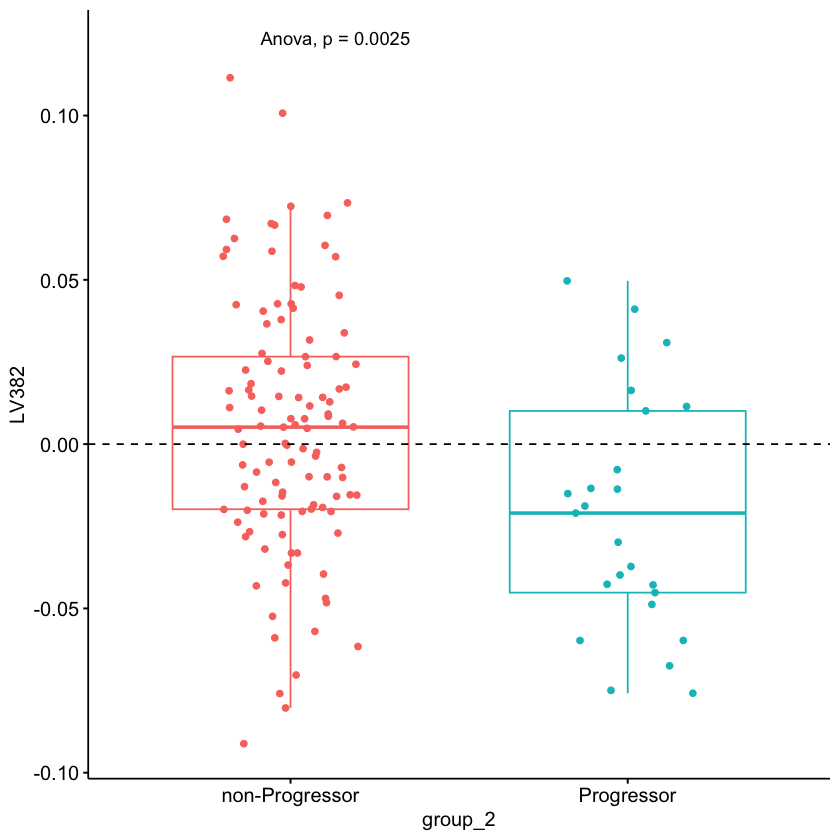

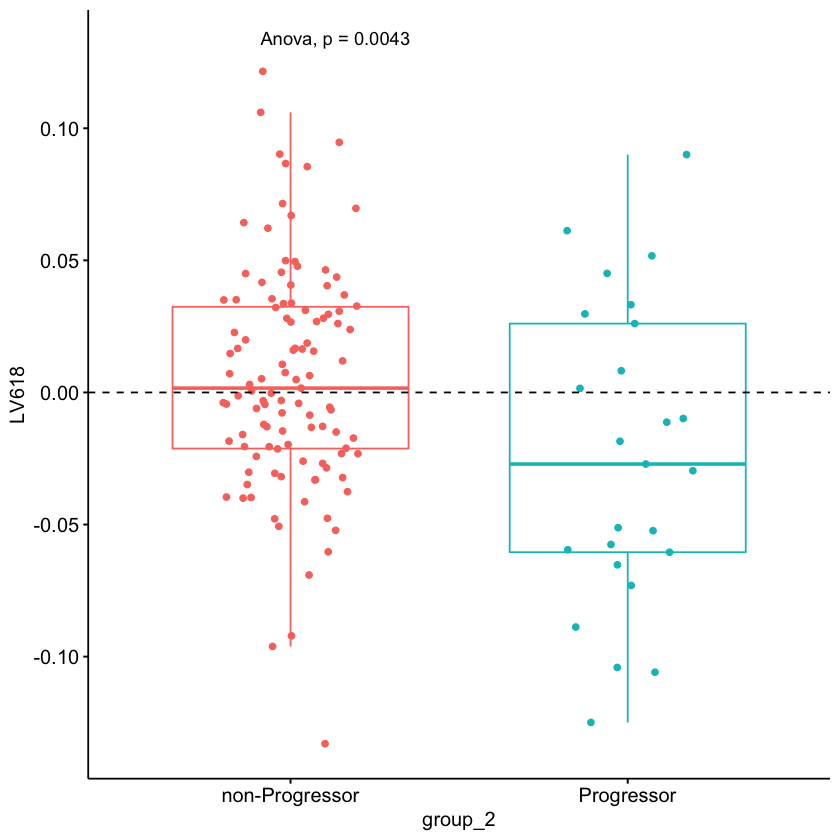

In [34]:
for (i in 1:length(sig_prog_non_prog$.y.)){
    plot_i <- ggboxplot(DAISY_prog, x = "group_2", y = sig_prog_non_prog$.y.[i], color = "group_2", 
          add = "jitter", legend = "none") +
  geom_hline(yintercept = mean(DAISY_rev[,sig_prog_non_prog$.y.[i]]), linetype = 2)+ # Add horizontal line at base mean
  stat_compare_means(method = "anova", label.y = max(DAISY_prog[,sig_prog_non_prog$.y.[i]])+ 0.01)       # Add global annova p-value 
    print(plot_i)+
    labs(x = "", y = sig_prog_non_prog$.y.[i]) +  # Change axis titles
  theme(
    axis.title.x = element_text(size = 40),  # Increase x-axis label size
    axis.title.y = element_text(size = 25),  # Increase y-axis label size
    axis.text.x = element_text(size = 25),   # Increase x-axis tick label size
    axis.text.y = element_text(size = 25)
      )
    #ggsave(paste0("LV_",T1D_LV[i],"_visit_",tp,".png"),path = paste0("figures/visit_",tp))
    } 
    #dev.off()



### Rev vs non-Rev

In [17]:
## Non normal data
all_wilcox <- c()
for (i in 1:length(non_norm_all_dat)) {
wilcox_out <- DAISY_rev%>%pairwise_wilcox_test(as.formula(paste0(non_norm_all_dat[i]," ~ group_2")))
wilcox_out$Comp <- paste0(str_sub(wilcox_out$group1, 1, 1),"x",str_sub(wilcox_out$group2, 1, 1))
all_wilcox <- rbind(all_wilcox,wilcox_out)
      }
new_data <- all_wilcox[,c(1,7,10)]
new_data$distribution <- "non-normal"
wider_wilcox <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

## Normal data
all_t.test <- c()
for (i in 1:length(normal_LV)) {
stat.test <- pairwise_t_test(DAISY_rev, as.formula(paste0(normal_LV[i]," ~ group_2")), paired = FALSE)
stat.test$Comp <- paste0(str_sub(stat.test$group1, 1, 1),"x",str_sub(stat.test$group2, 1, 1))
all_t.test <- rbind(all_t.test,stat.test)
      }
new_data <- all_t.test[,c(1,6,10)]
new_data$distribution <- "normal"
wider_t.test <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

all_data_test <- rbind(wider_wilcox,wider_t.test)
# adjsut p values for multiple comparison
all_data_test$p.adj.nxR <- p.adjust(all_data_test$nxR, method = "bonferroni")

In [18]:
# LVs expresed differentially accross groups at p-value < 0.005
sig_rev_non_rev <- all_data_test[all_data_test$nxR <0.005,]
dim(sig_rev_non_rev)
datatable(sig_rev_non_rev)

[1] 20  4

HTML widgets cannot be represented in plain text (need html)

##### Boxplots of LVs that differentiate Reverter from non-reverter

In [19]:
# for (i in 1:length(sig_rev_non_rev$.y.)) {
#     # Create the plot
#     myplot <- ggboxplot(DAISY_rev, x = "group_2", y = sig_rev_non_rev$.y.[i])
#     print(myplot)
#     }

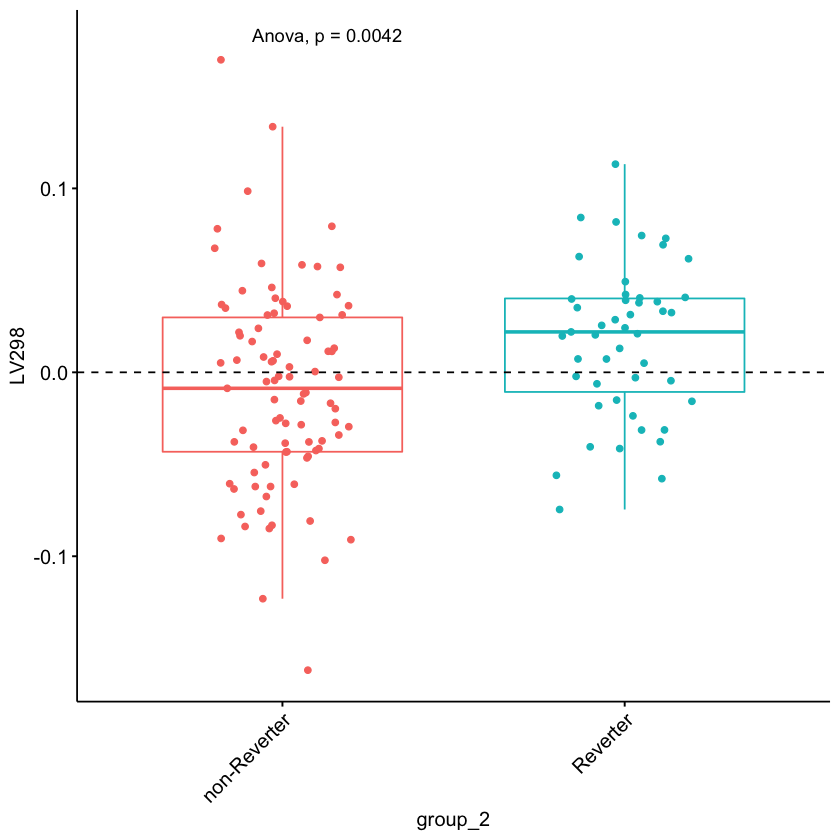

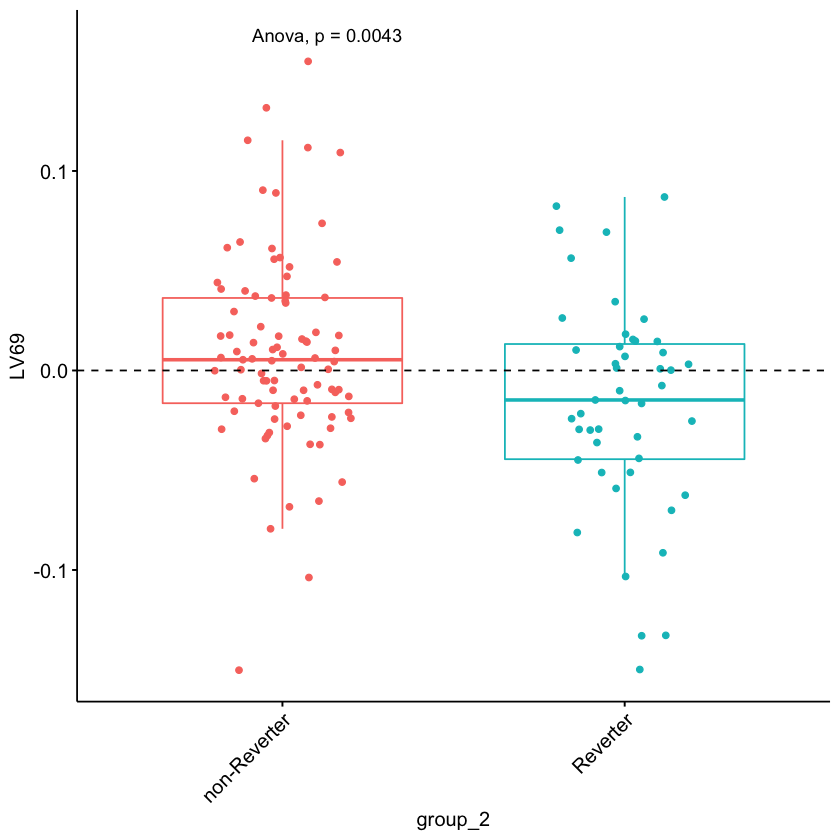

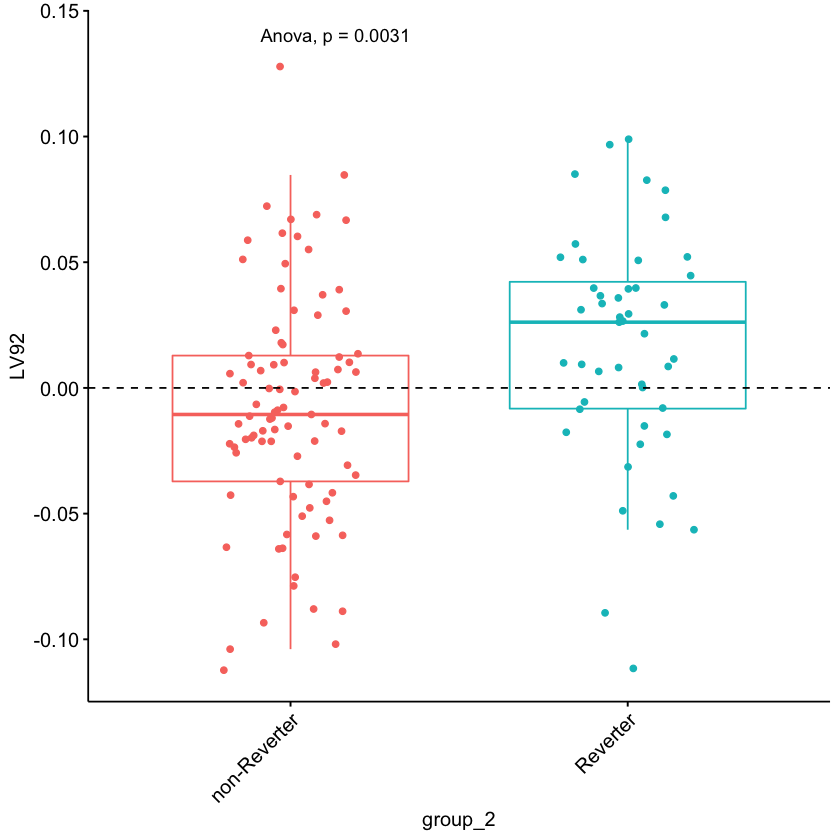

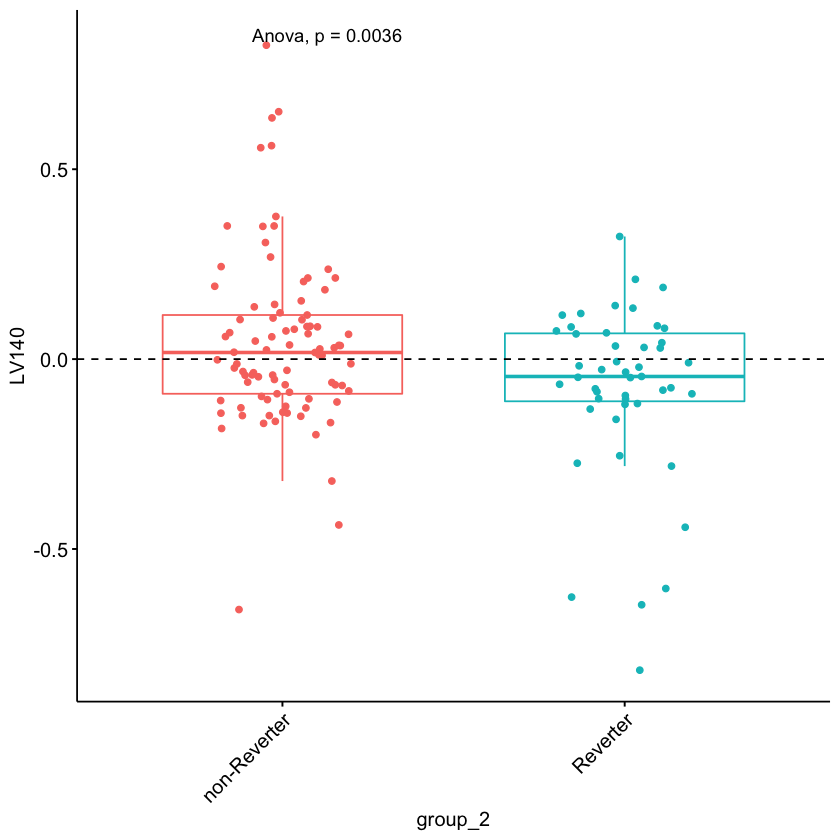

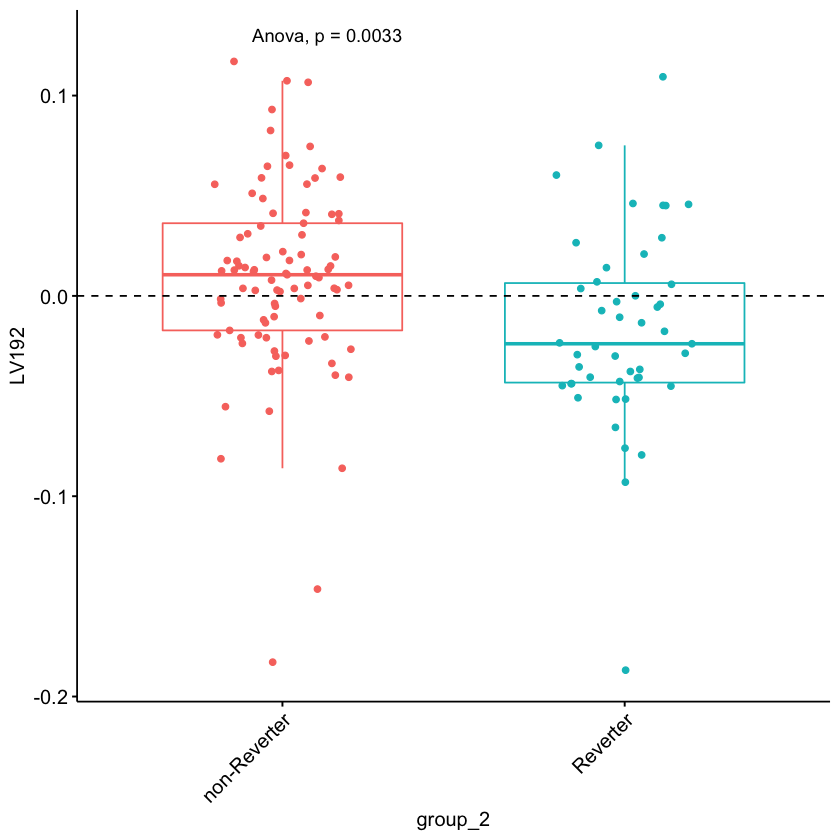

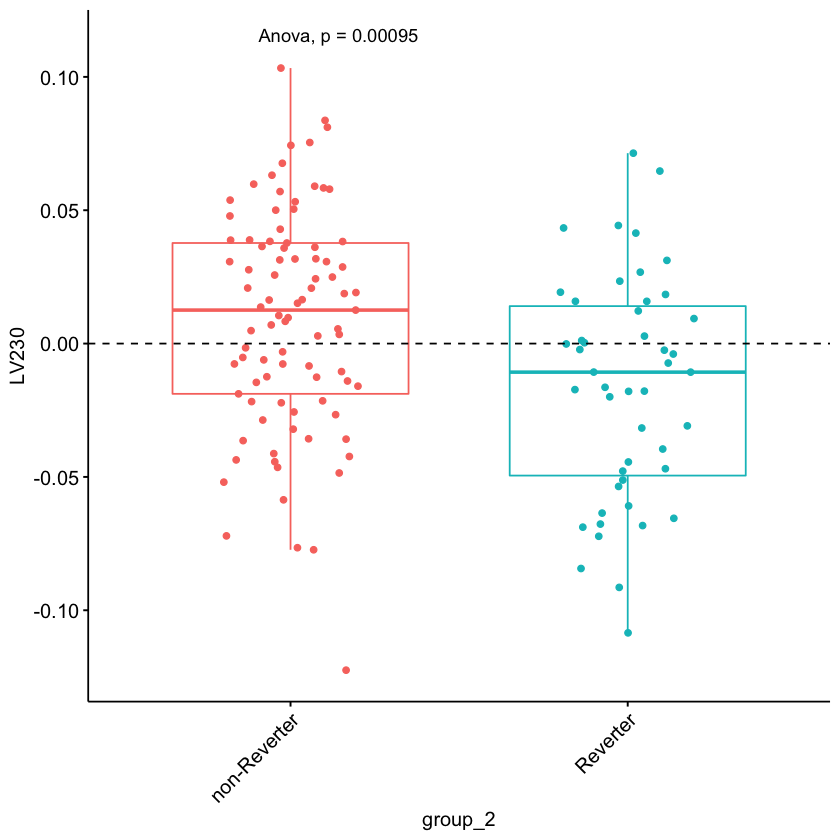

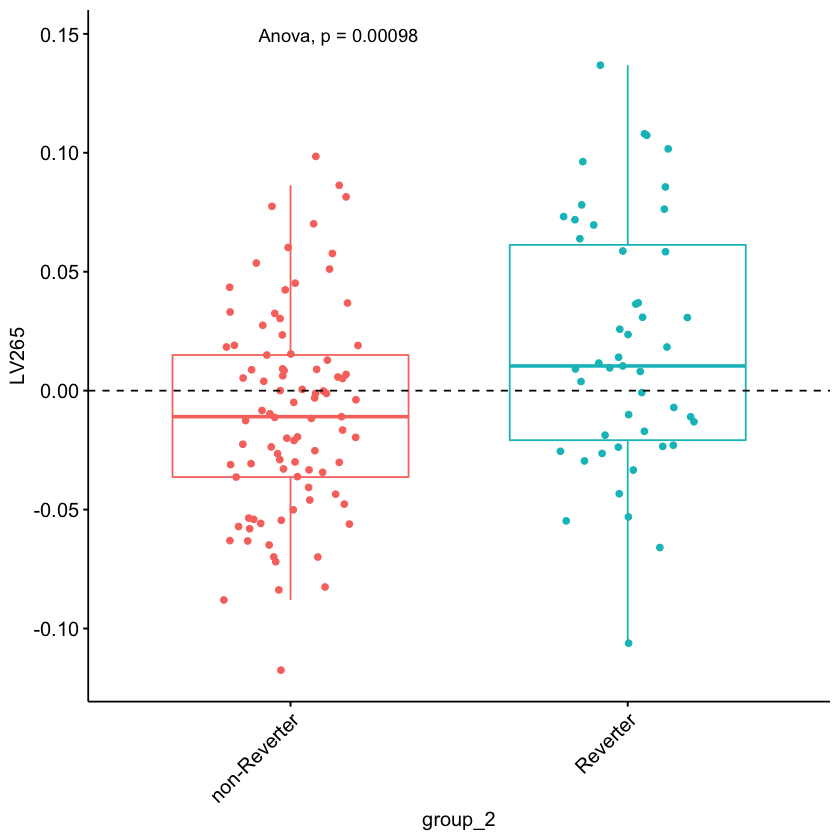

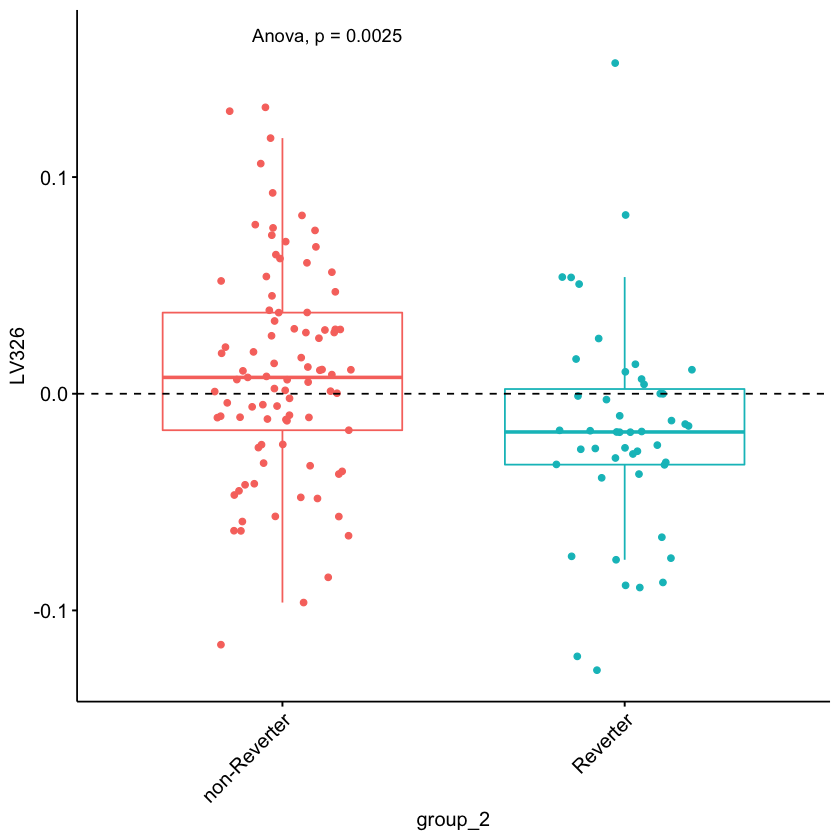

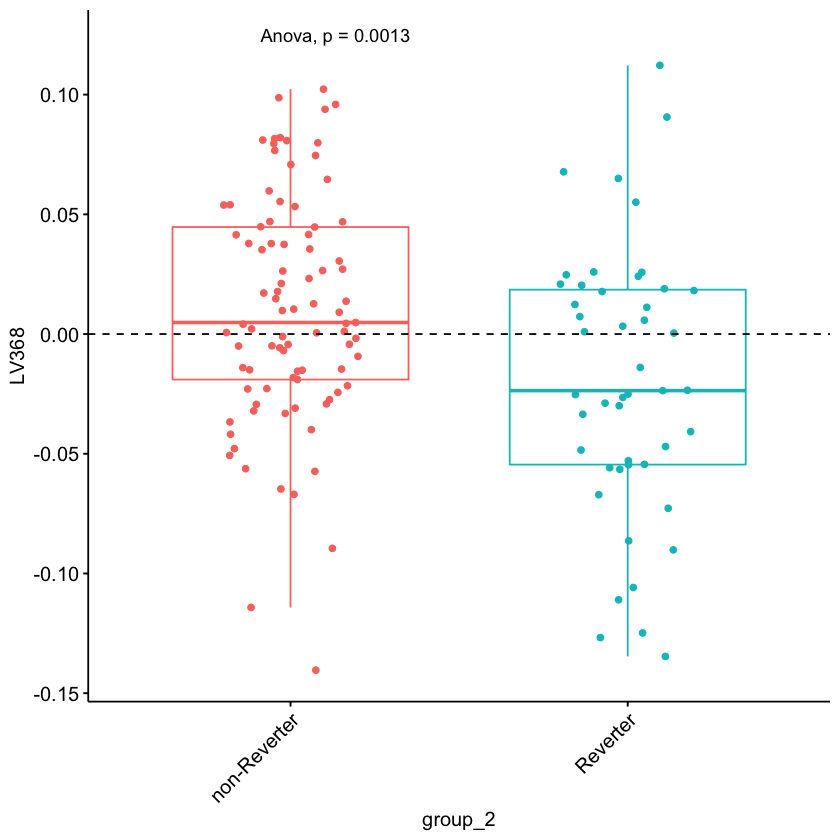

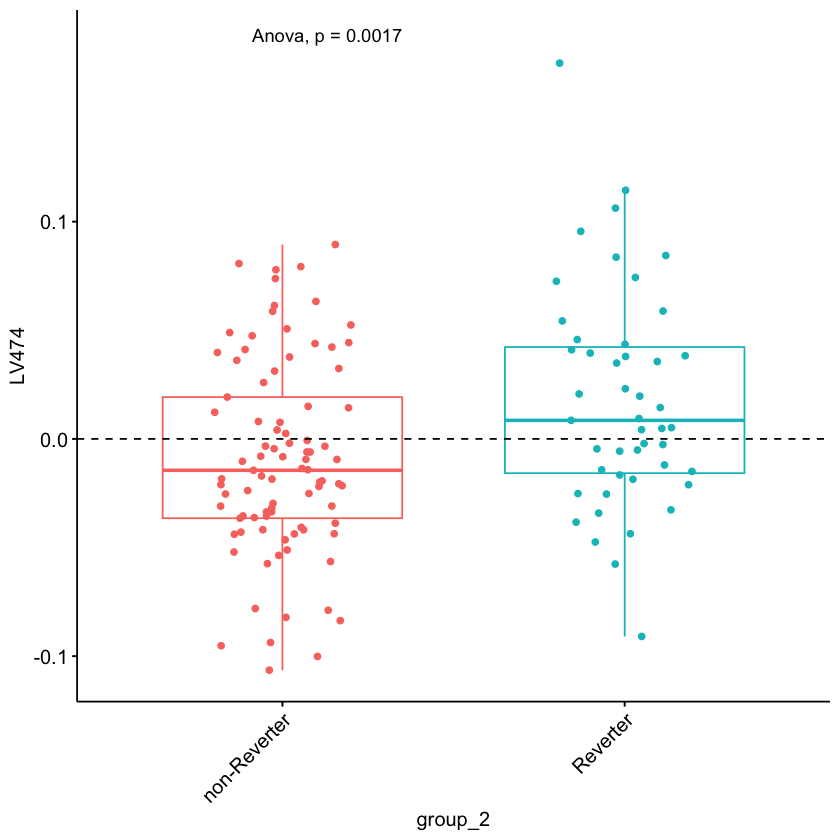

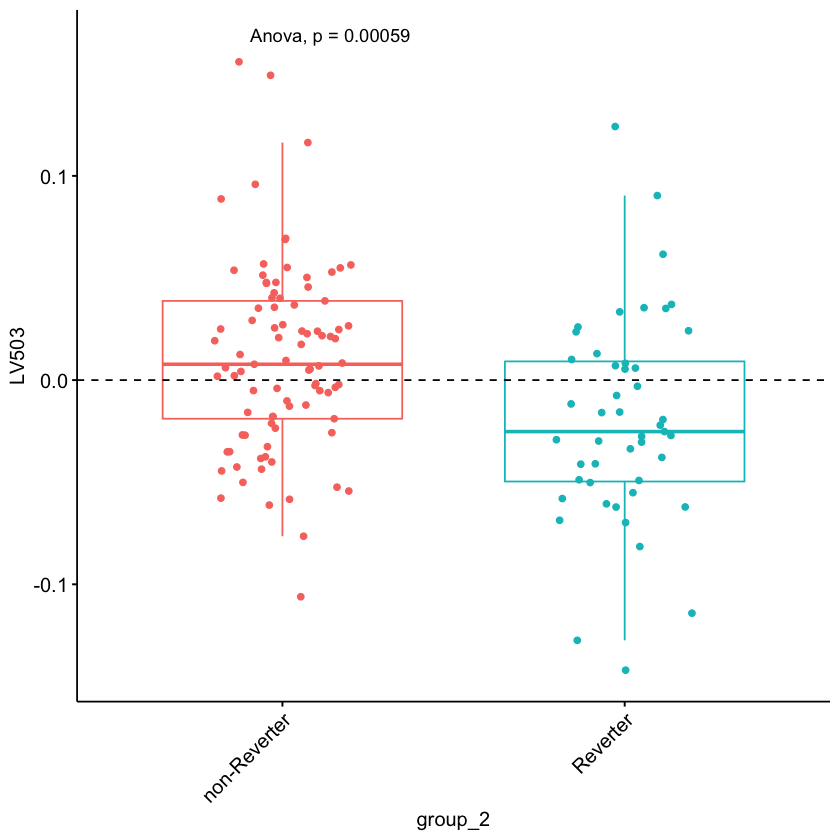

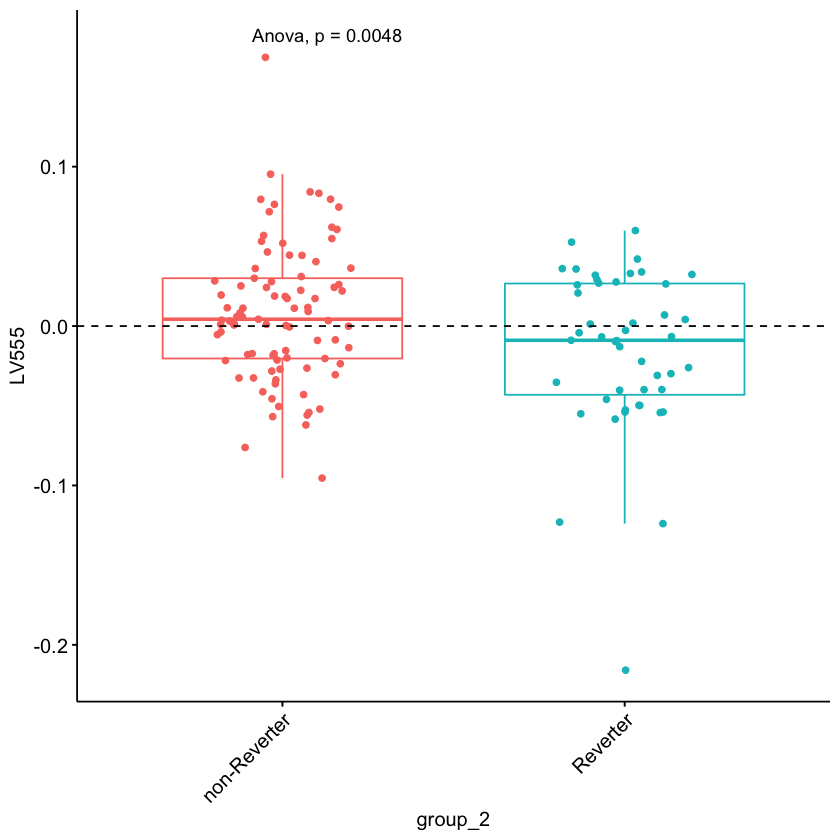

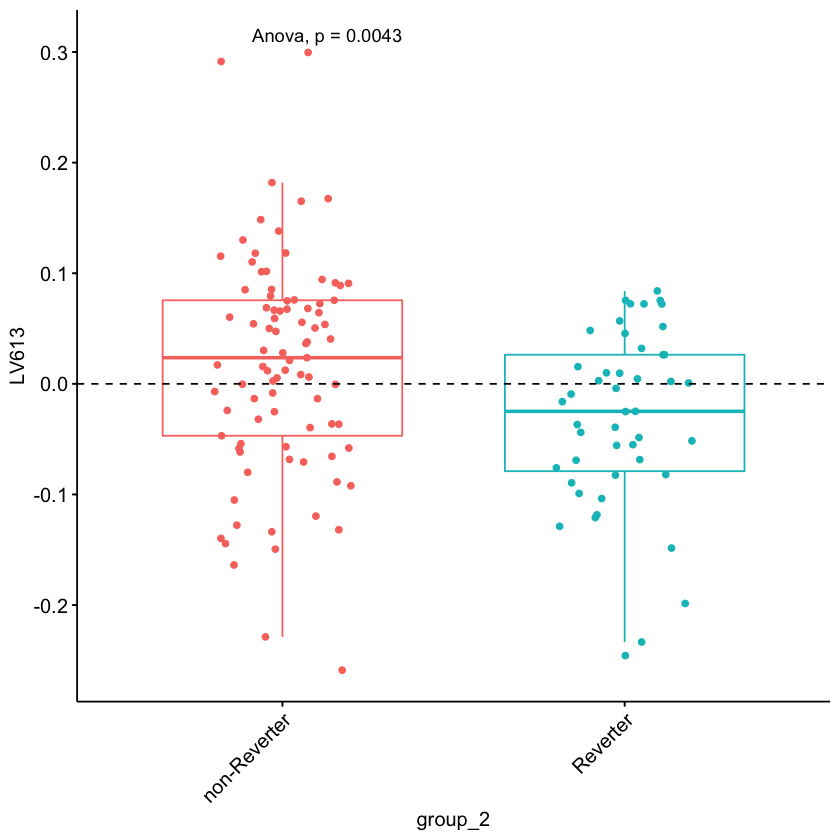

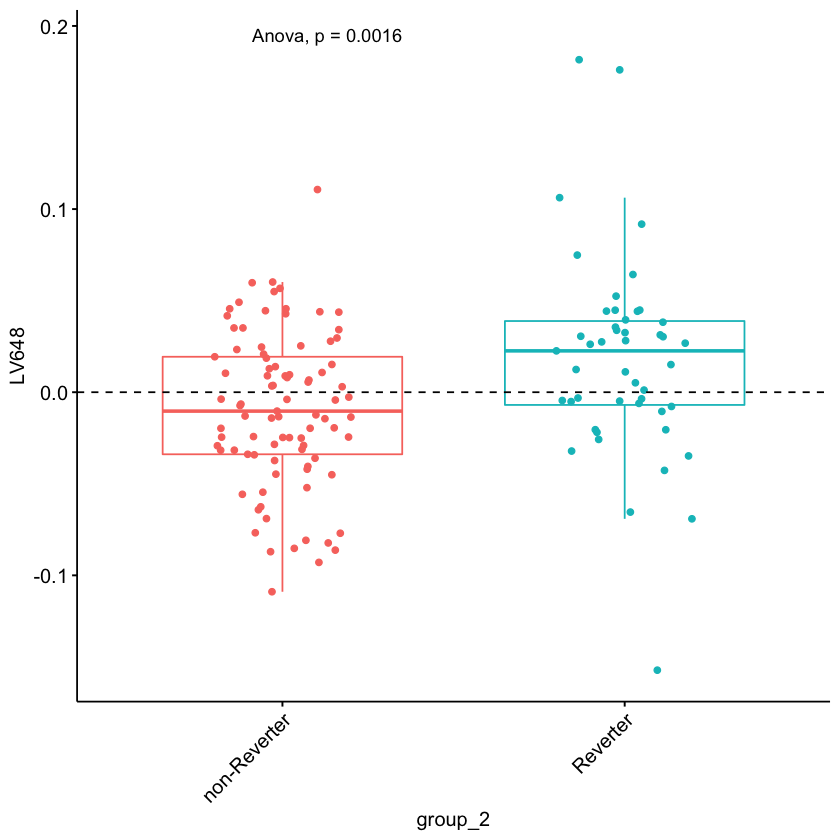

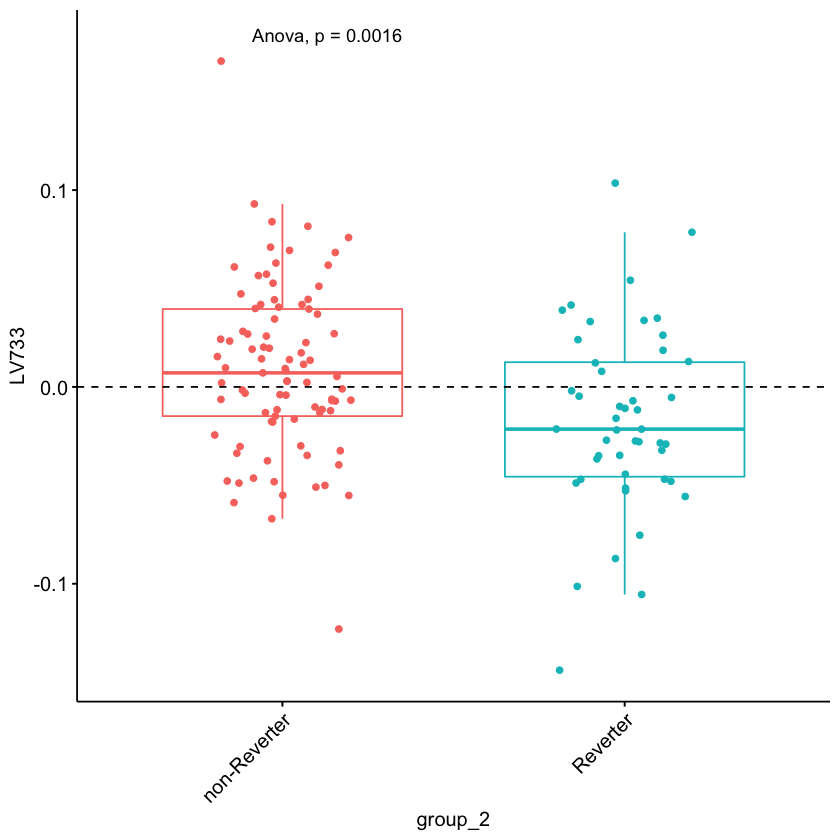

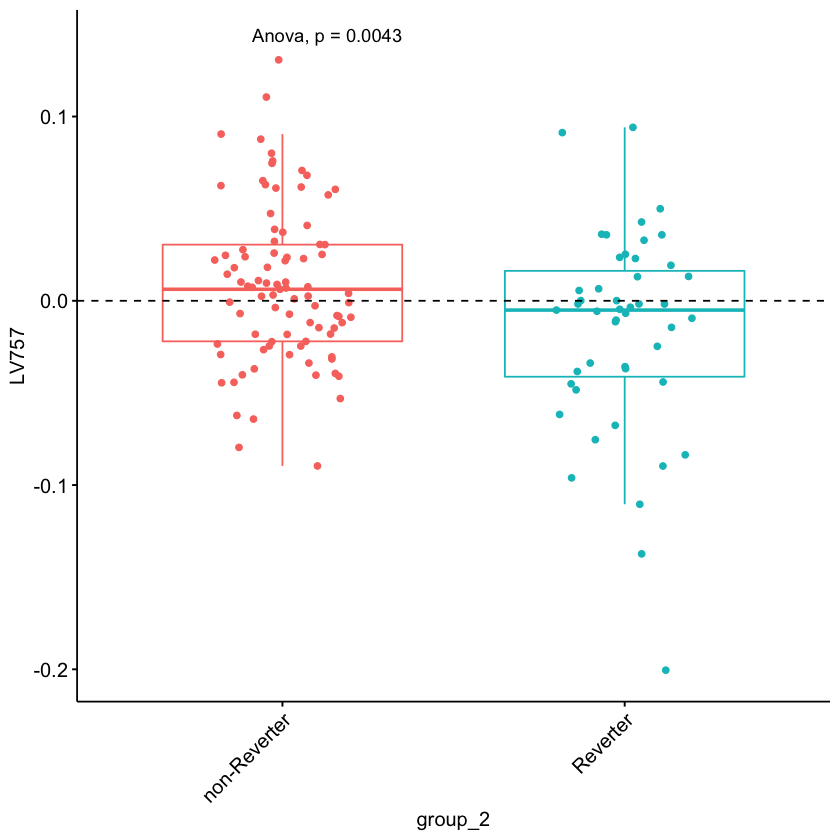

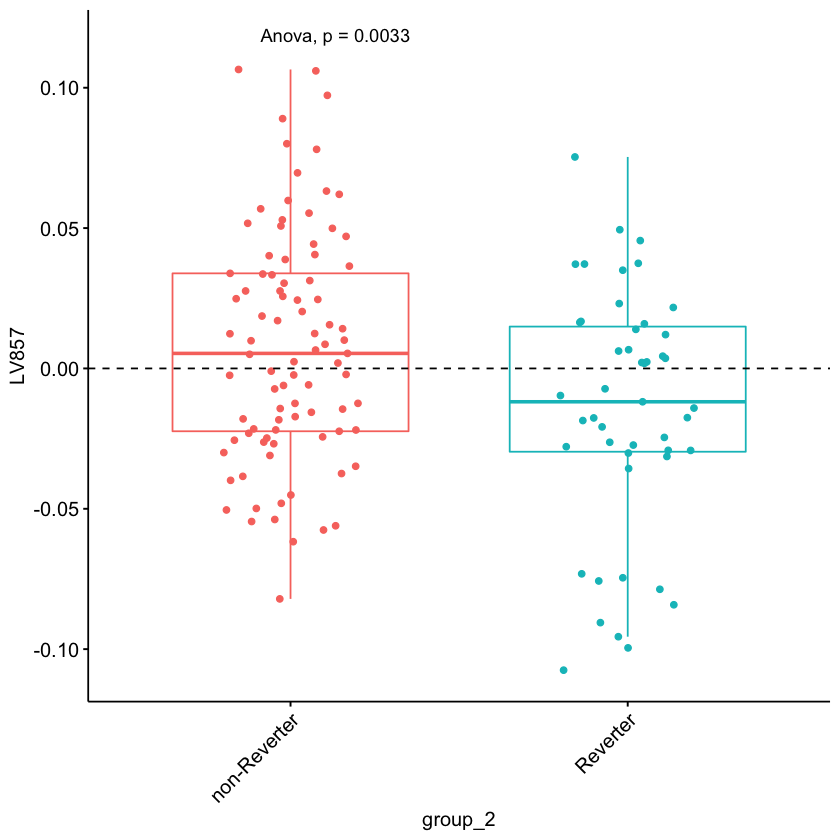

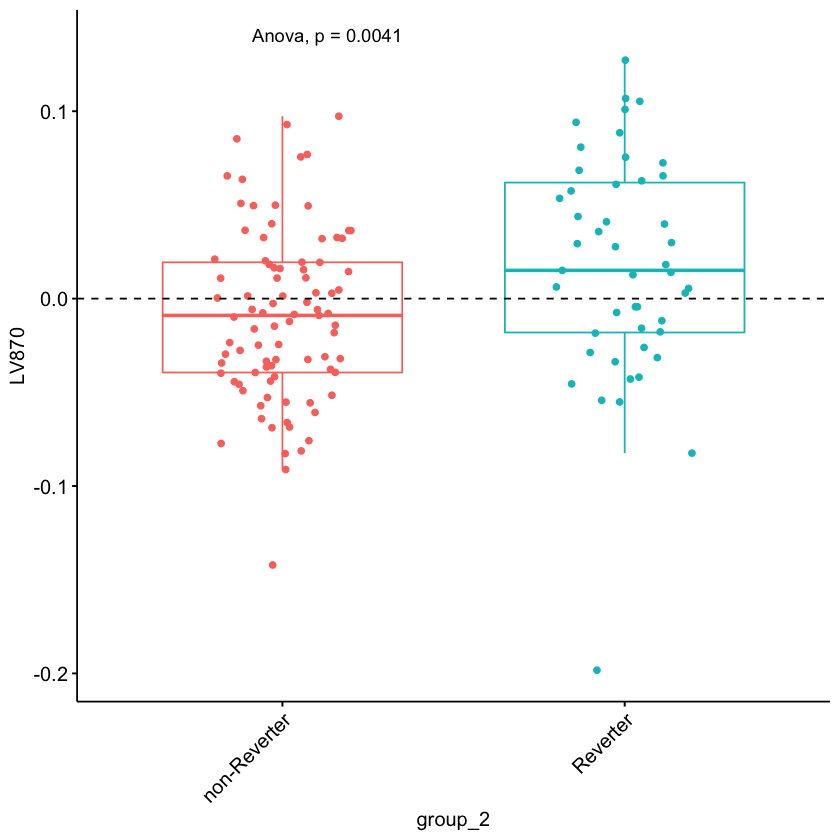

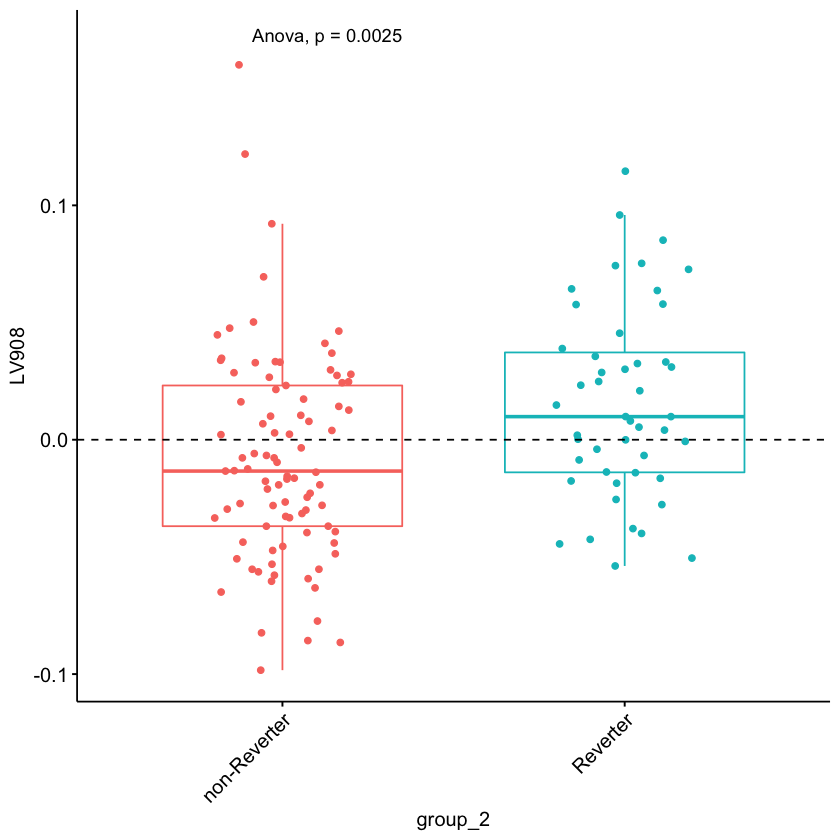

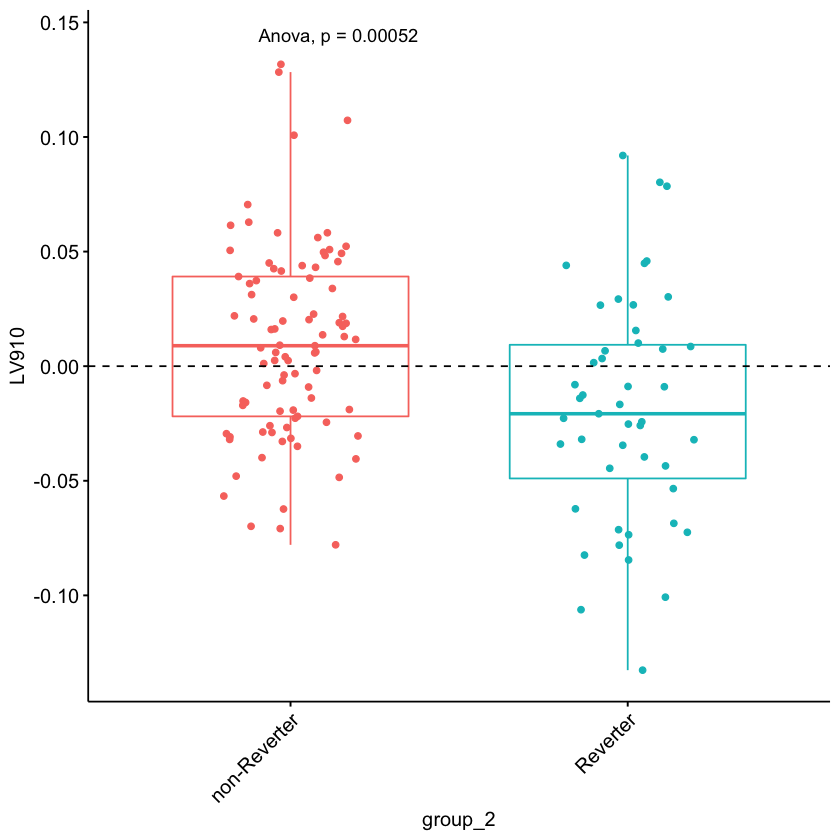

In [20]:
for (i in 1:length(sig_rev_non_rev$.y.)){
    plot_i <- ggboxplot(DAISY_rev, x = "group_2", y = sig_rev_non_rev$.y.[i], color = "group_2", 
          add = "jitter", legend = "none") +
  rotate_x_text(angle = 45)+
  geom_hline(yintercept = mean(DAISY_rev[,sig_rev_non_rev$.y.[i]]), linetype = 2)+ # Add horizontal line at base mean
  stat_compare_means(method = "anova", label.y = max(DAISY_rev[,sig_rev_non_rev$.y.[i]])+ 0.01)       # Add global annova p-value 
    print(plot_i)
    
    #ggsave(paste0("LV_",T1D_LV[i],"_visit_",tp,".png"),path = paste0("figures/visit_",tp))
    } 
    #dev.off()

### Main vs non-Main

In [24]:
## Non normal data
all_wilcox <- c()
for (i in 1:length(non_norm_all_dat)) {
wilcox_out <- DAISY_main%>%pairwise_wilcox_test(as.formula(paste0(non_norm_all_dat[i]," ~ group_2")))
wilcox_out$Comp <- paste0(str_sub(wilcox_out$group1, 1, 1),"x",str_sub(wilcox_out$group2, 1, 1))
all_wilcox <- rbind(all_wilcox,wilcox_out)
      }
new_data <- all_wilcox[,c(1,7,10)]
new_data$distribution <- "non-normal"
wider_wilcox <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

## Normal data
all_t.test <- c()
for (i in 1:length(normal_LV)) {
stat.test <- pairwise_t_test(DAISY_main, as.formula(paste0(normal_LV[i]," ~ group_2")), paired = FALSE)
stat.test$Comp <- paste0(str_sub(stat.test$group1, 1, 1),"x",str_sub(stat.test$group2, 1, 1))
all_t.test <- rbind(all_t.test,stat.test)
      }
new_data <- all_t.test[,c(1,6,10)]
new_data$distribution <- "normal"
wider_t.test <- pivot_wider(new_data, names_from = Comp, values_from = c("p"), names_sep = ".")

all_data_test <- rbind(wider_wilcox,wider_t.test)
# adjsut p values for multiple comparison
all_data_test$p.adj.Mxn <- p.adjust(all_data_test$Mxn, method = "bonferroni")

In [25]:
# LVs expresed differentially accross groups at p-value < 0.005
sig_main_non_main <- all_data_test[all_data_test$Mxn <0.005,]
dim(sig_main_non_main)
datatable(sig_main_non_main)

[1] 12  4

HTML widgets cannot be represented in plain text (need html)

##### Boxplots of LVs that differentiate Maintainer from non-maintainer

In [ ]:
# for (i in 1:length(sig_rev_non_rev$.y.)) {
#     # Create the plot
#     myplot <- ggboxplot(DAISY_rev, x = "group_2", y = sig_rev_non_rev$.y.[i])
#     print(myplot)
#     }

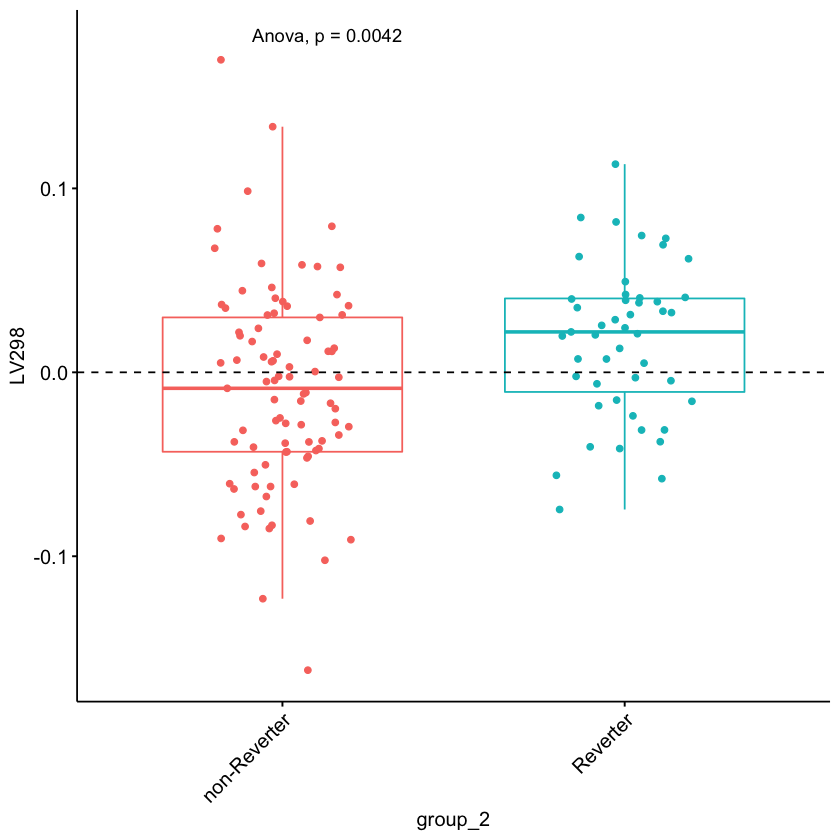

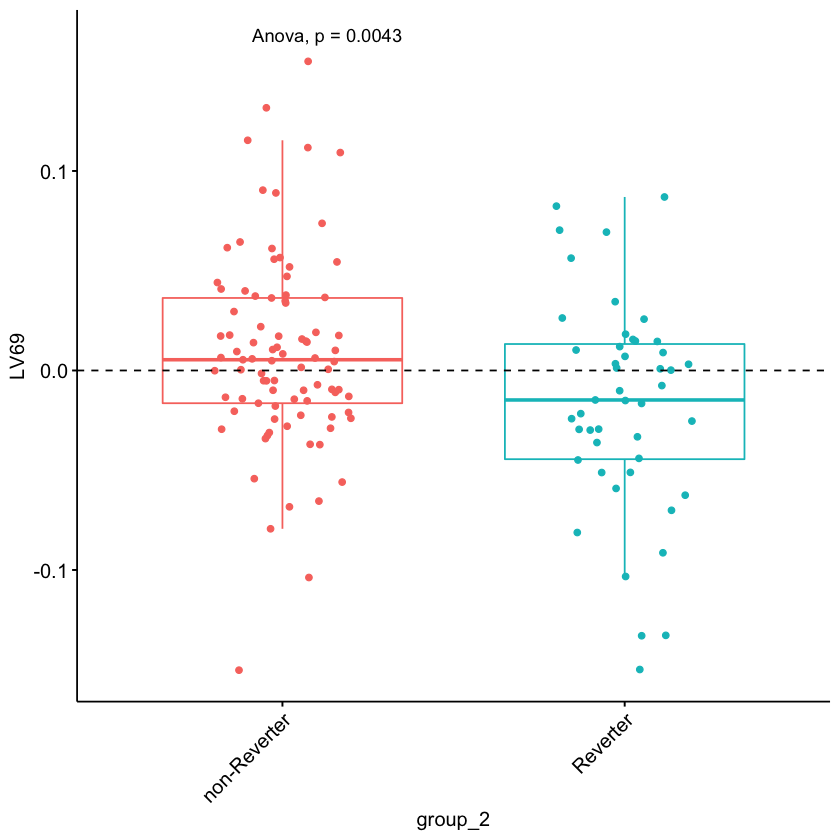

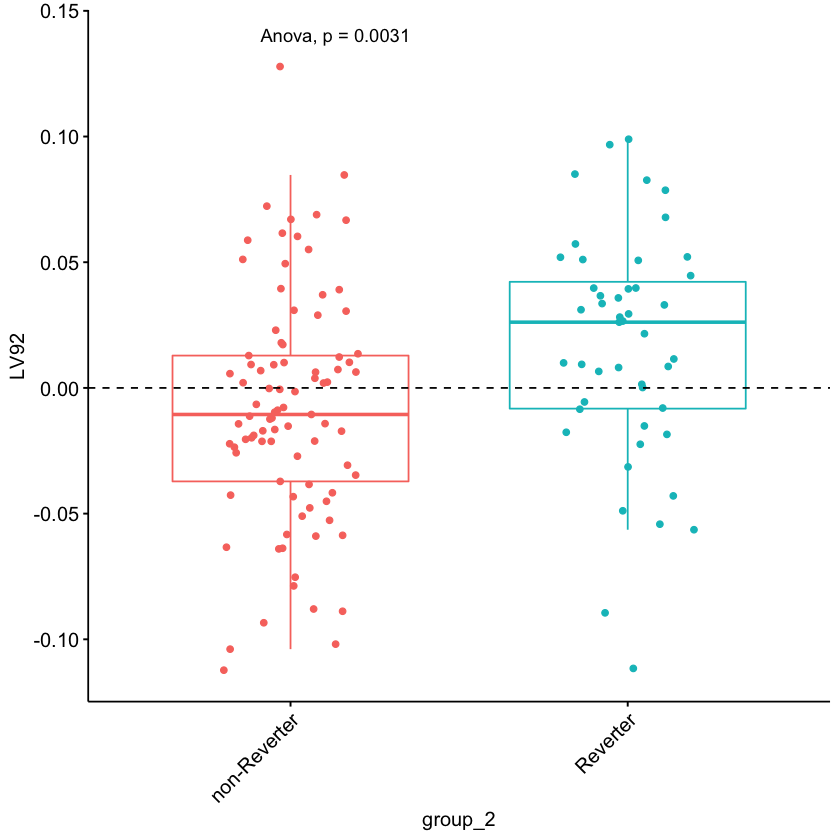

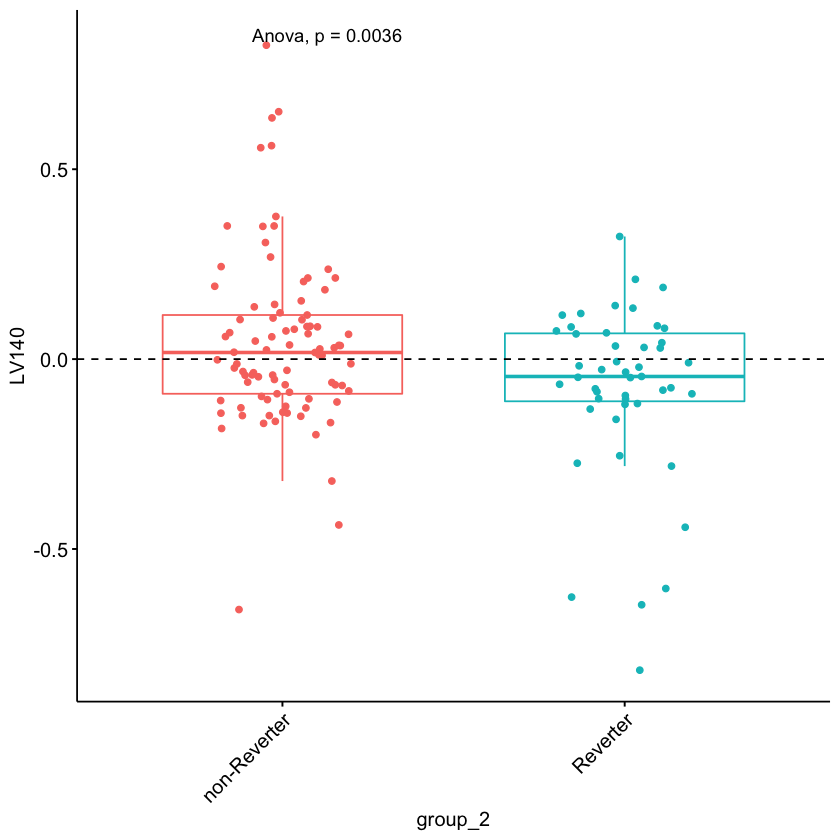

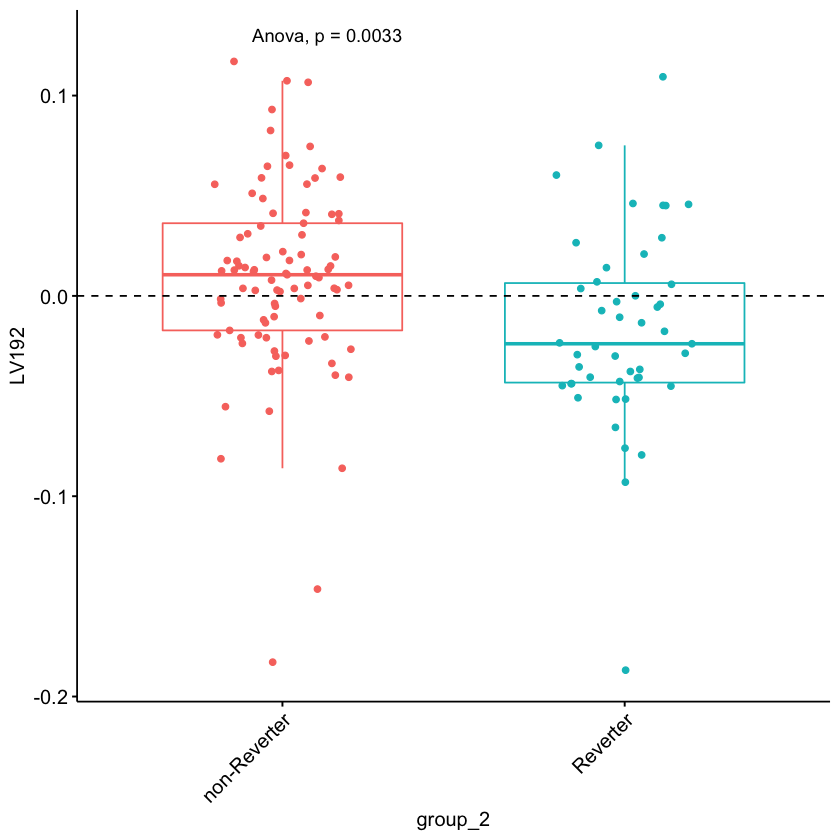

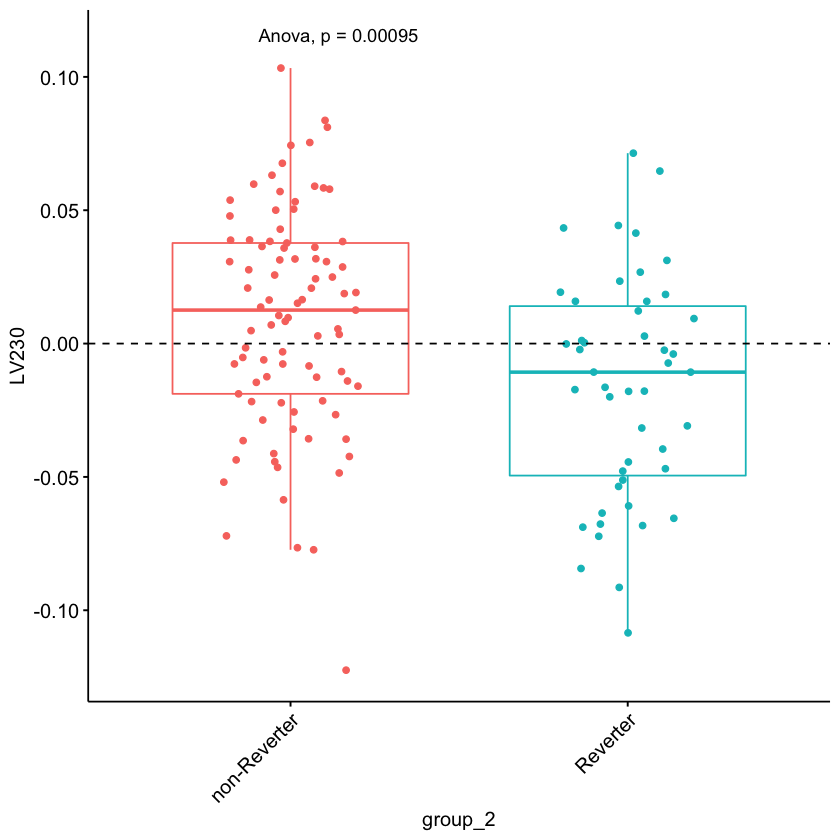

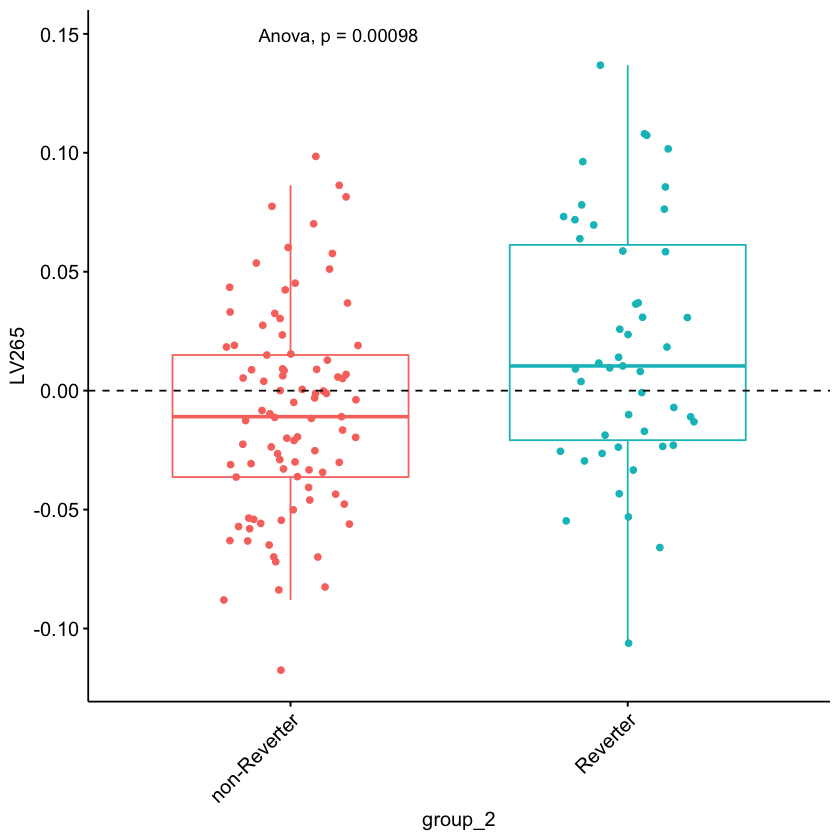

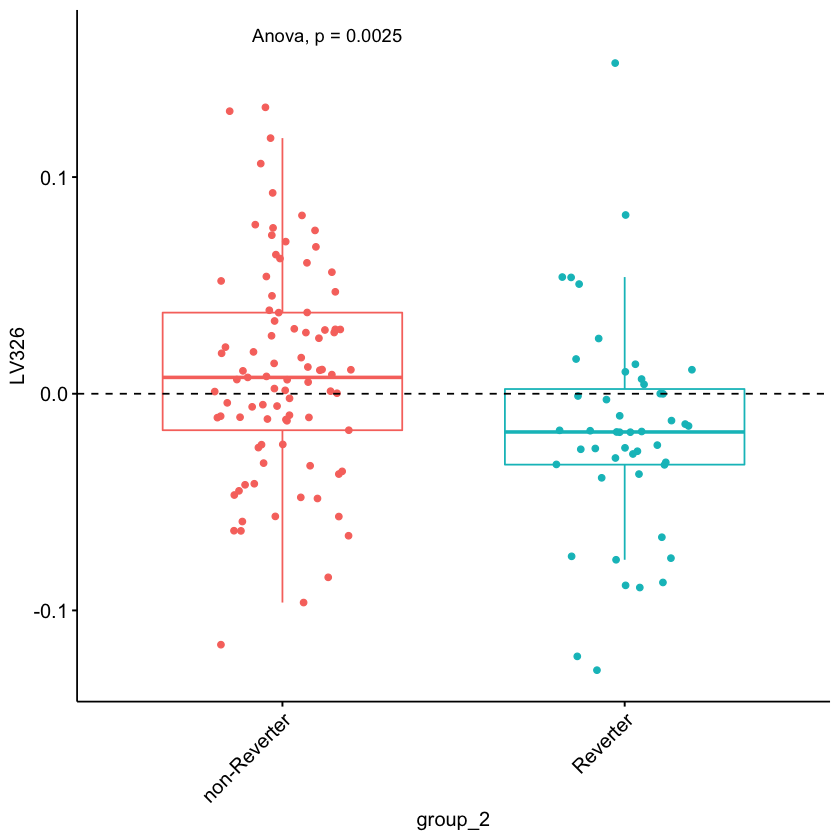

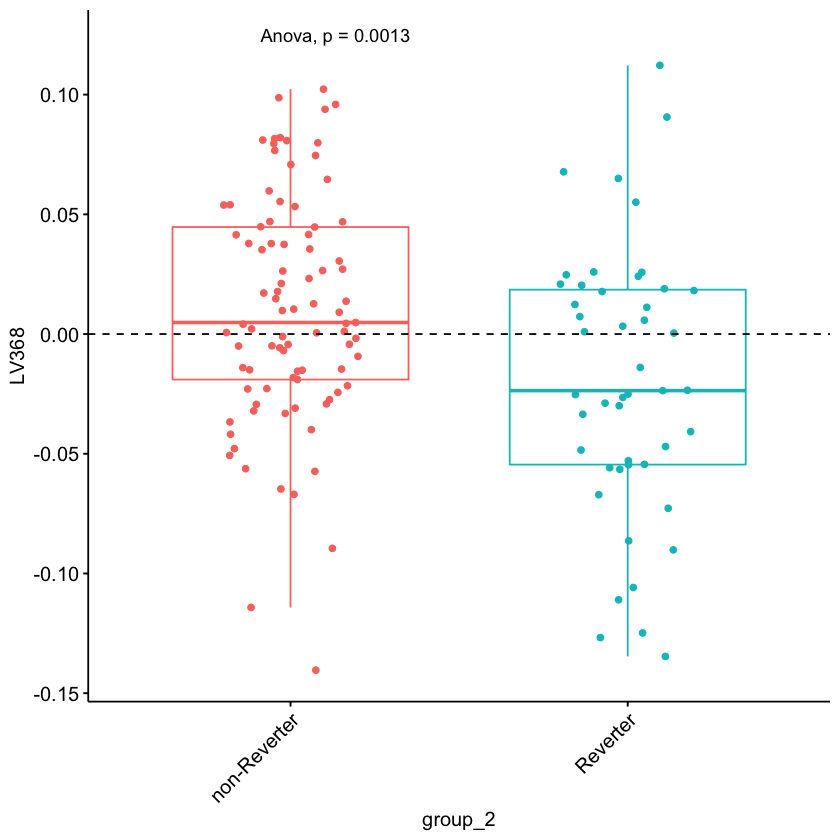

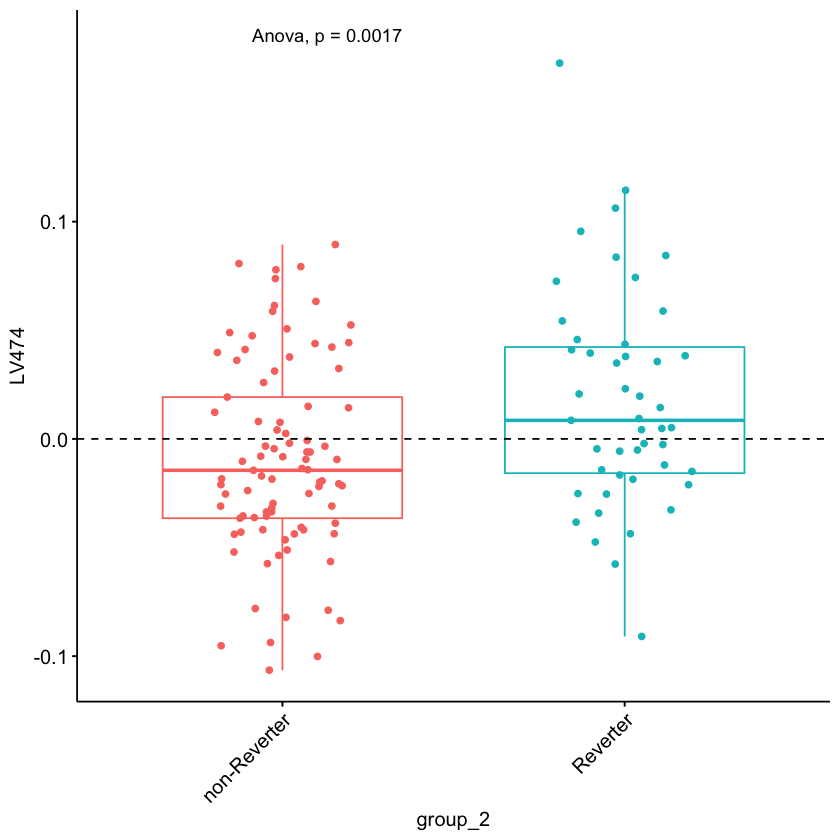

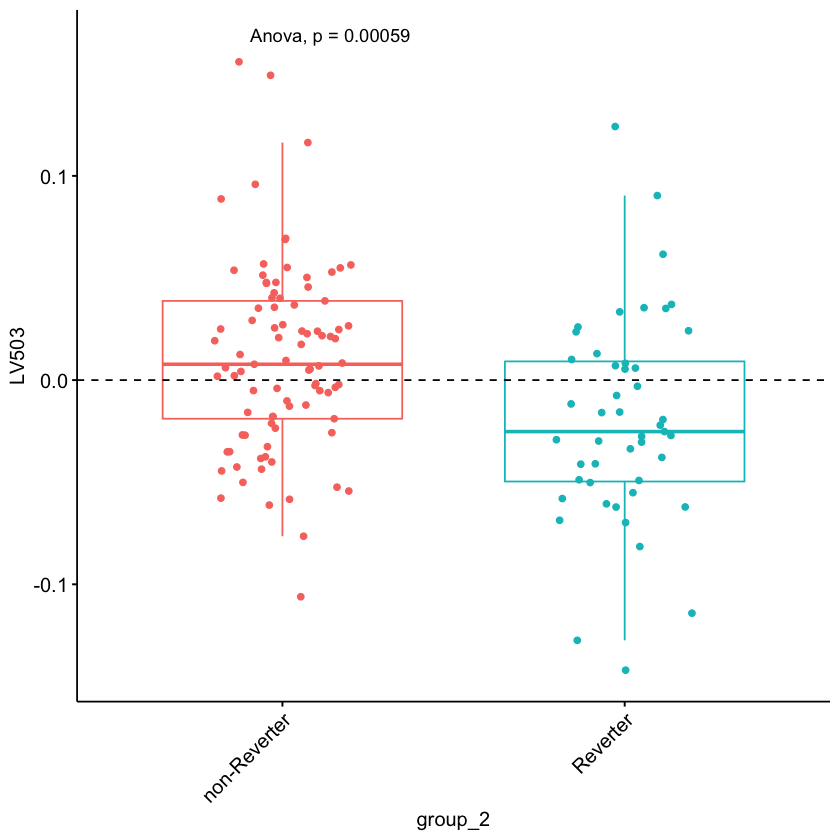

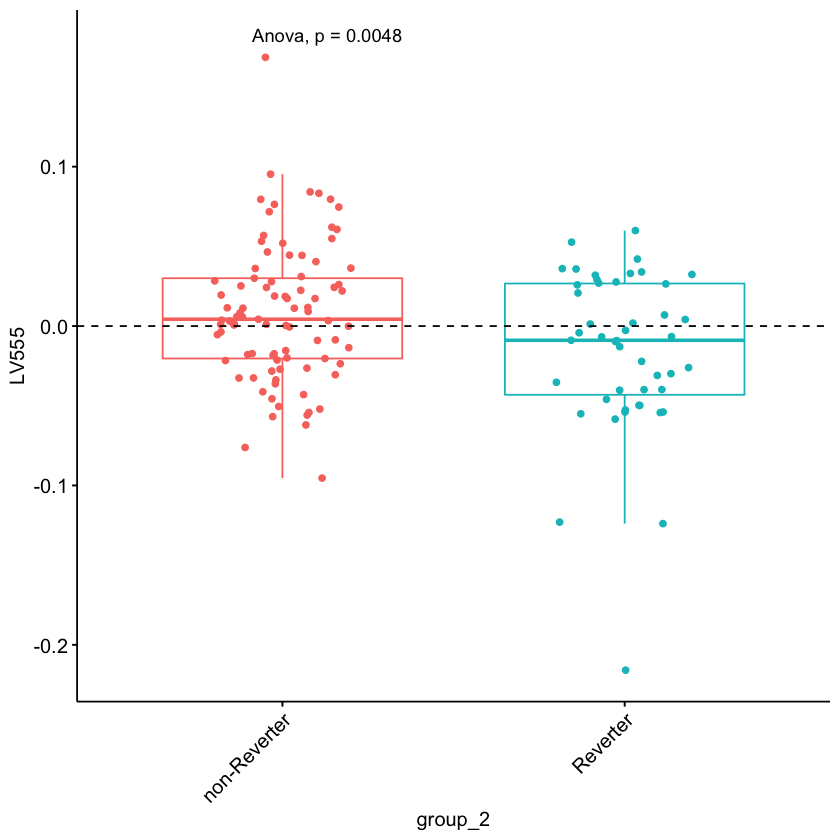

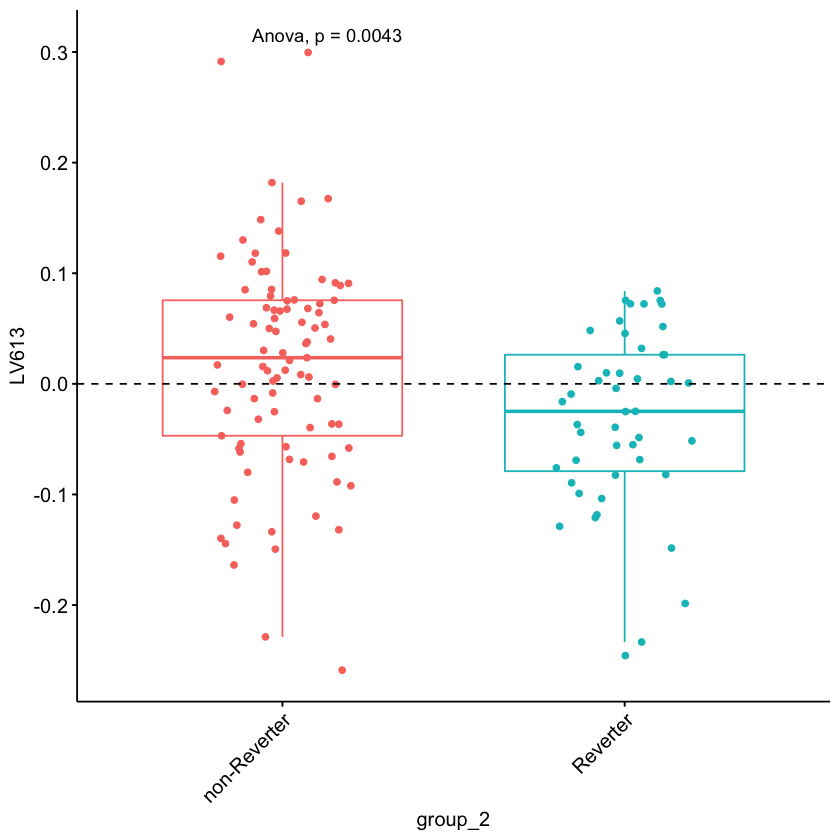

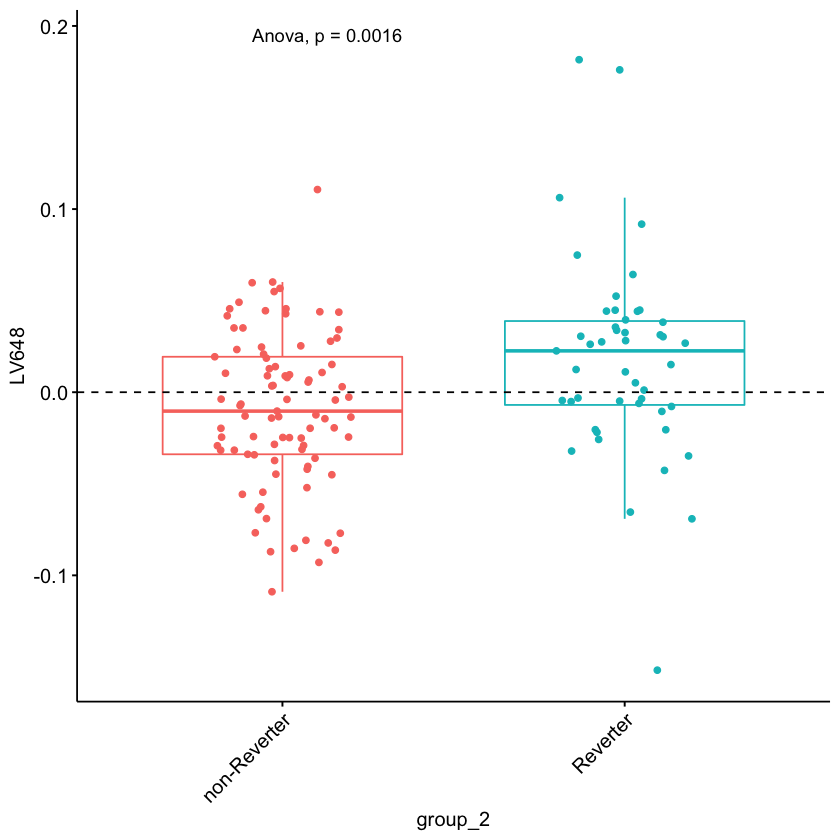

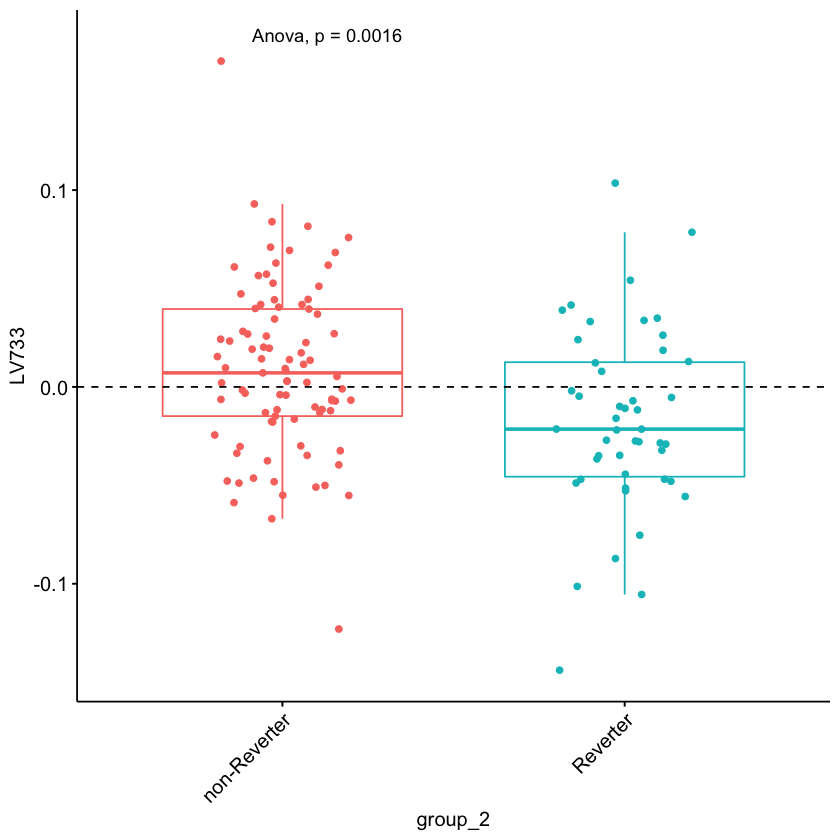

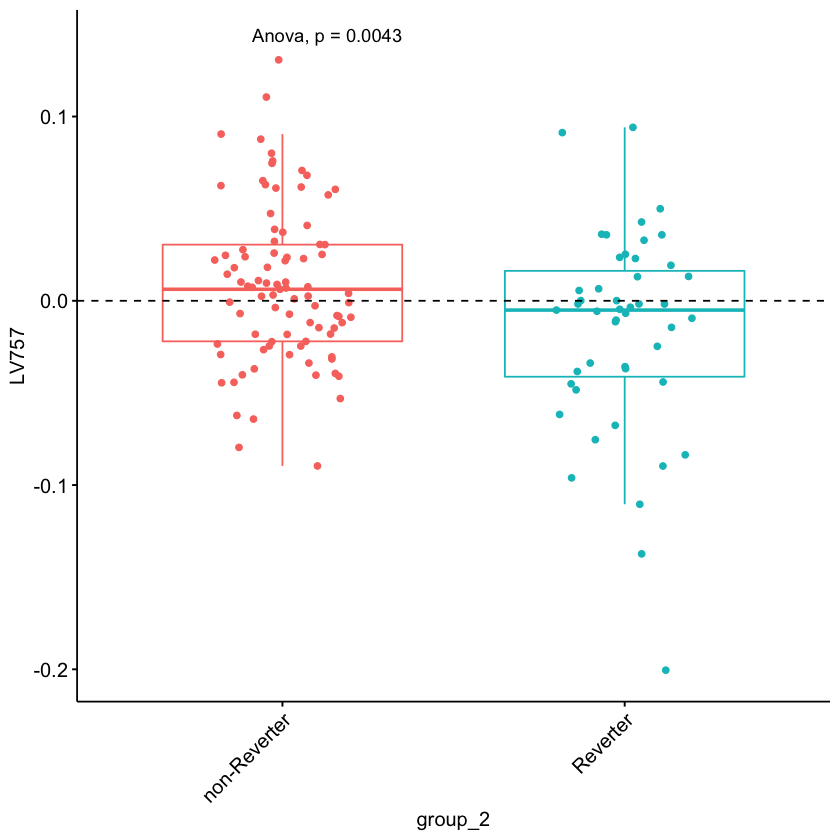

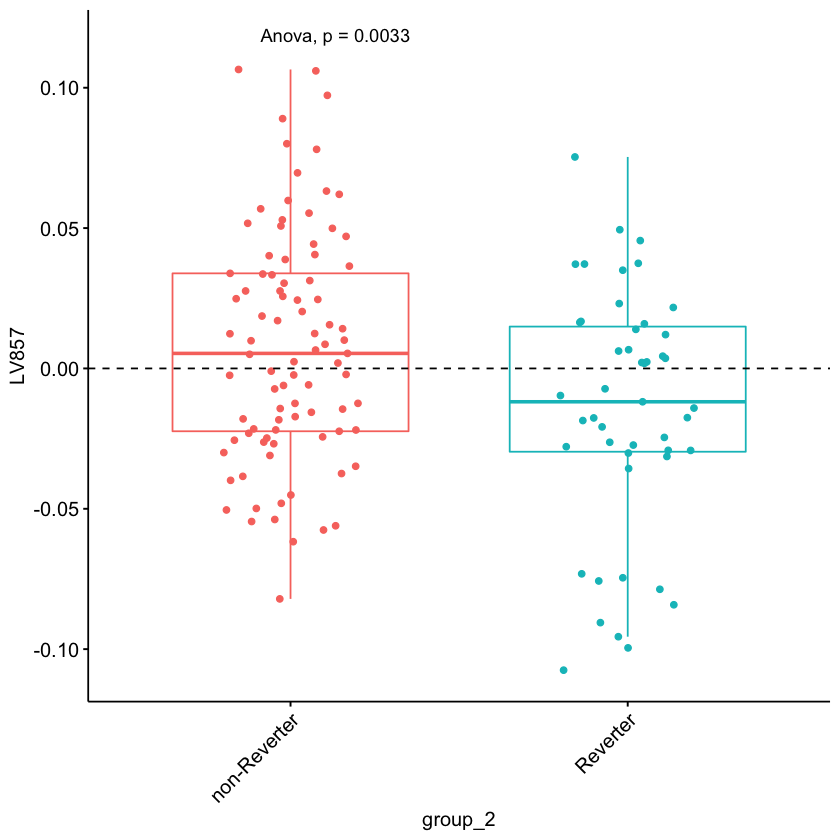

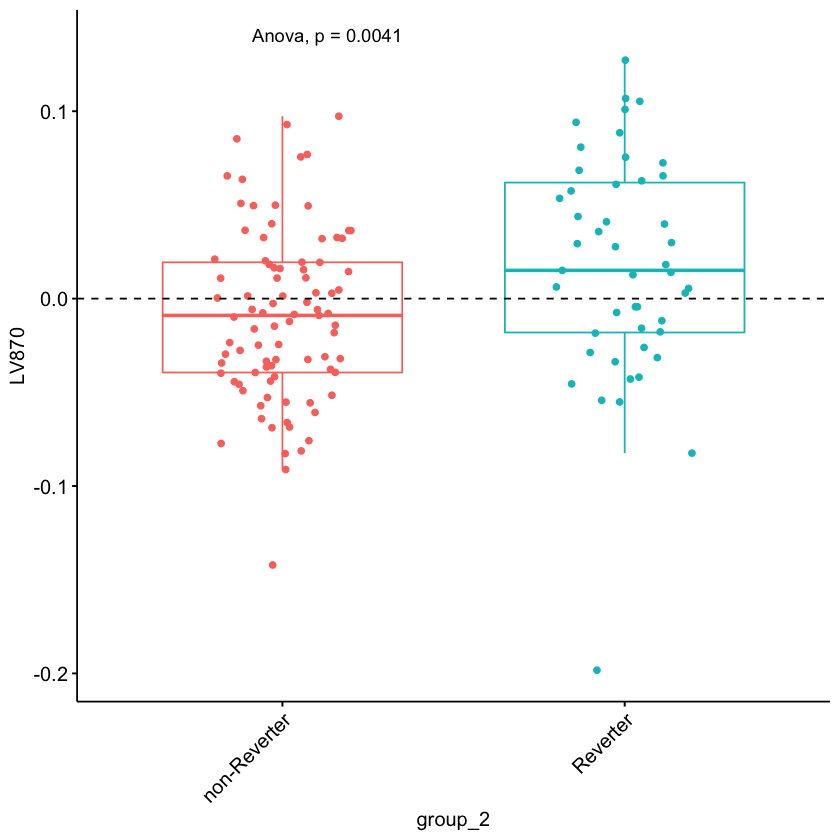

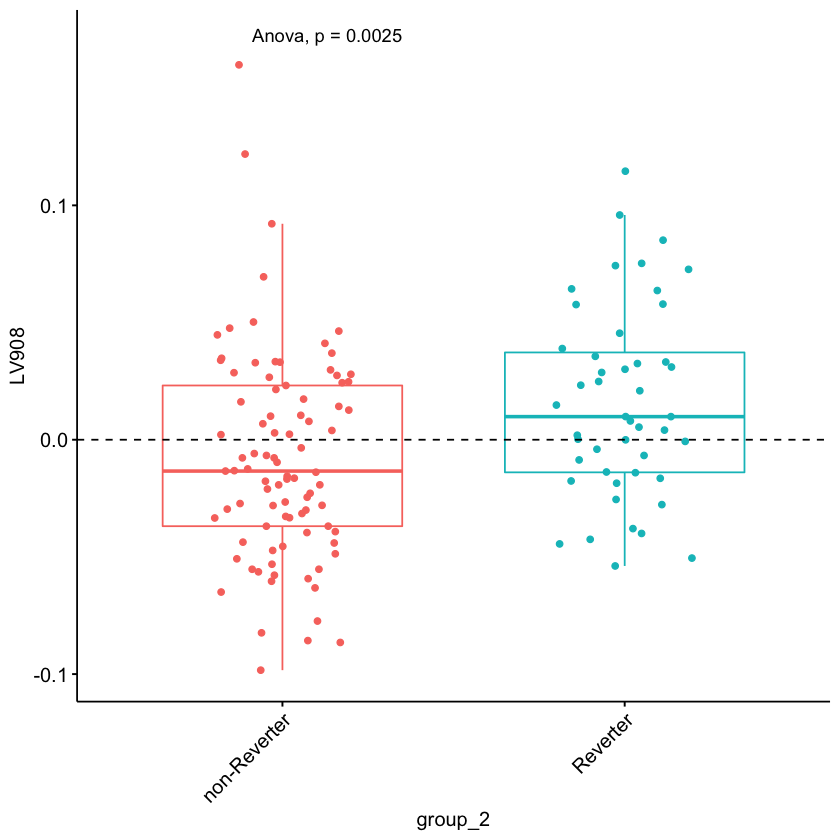

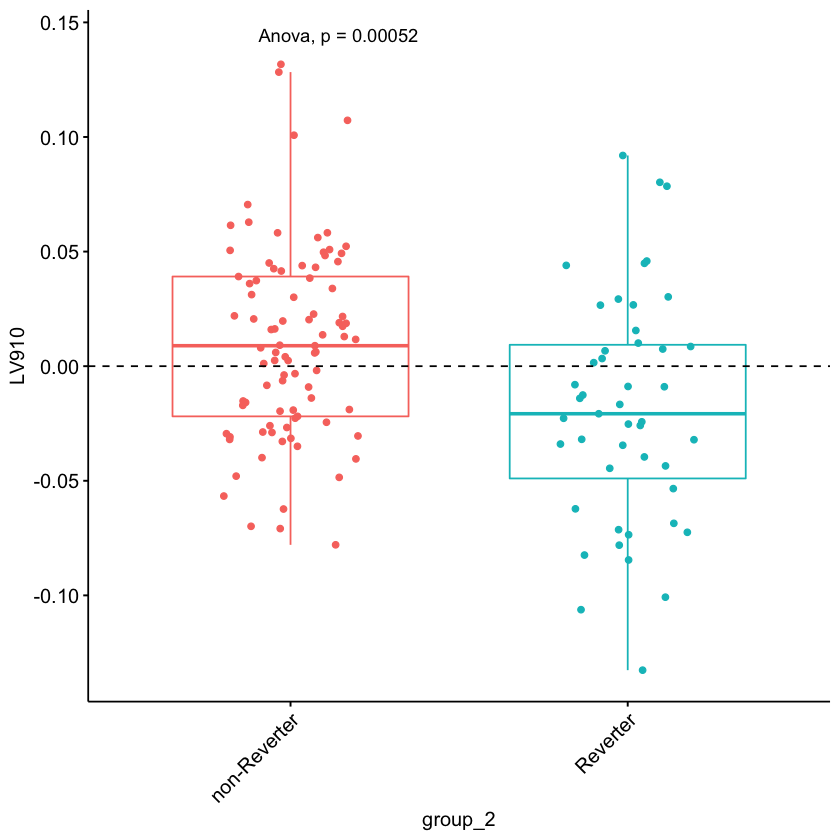

In [21]:
for (i in 1:length(sig_main_non_main$.y.)){
    plot_i <- ggboxplot(DAISY_main, x = "group_2", y = sig_main_non_main$.y.[i], color = "group_2", 
          add = "jitter", legend = "none") +
  rotate_x_text(angle = 45)+
  geom_hline(yintercept = mean(DAISY_main[,sig_main_non_main$.y.[i]]), linetype = 2)+ # Add horizontal line at base mean
  stat_compare_means(method = "anova", label.y = max(DAISY_main[,sig_main_non_main$.y.[i]])+ 0.01)       # Add global annova p-value 
    print(plot_i)
    
    #ggsave(paste0("LV_",T1D_LV[i],"_visit_",tp,".png"),path = paste0("figures/visit_",tp))
    } 
    #dev.off()